In [19]:
!pip install opendatasets


In [20]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/ziya07/plant-health-data?select=plant_health_data.csv")

Skipping, found downloaded files in "./plant-health-data" (use force=True to force download)


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [74]:
df = pd.read_csv('/content/plant-health-data/plant_health_data.csv')

In [75]:
# Display basic information about the dataset
print("Shape of the dataset:", df.shape)
display(df.head())
print("\nDataset Information:")
print(df.info())
print("\nStatistical Summary:")
display(df.describe().T)

Shape of the dataset: (1200, 14)


Timestamp  Plant_ID  Soil_Moisture  Ambient_Temperature  \
0  2024-10-03 10:54:53.407995         1      27.521109            22.240245   
1  2024-10-03 16:54:53.407995         1      14.835566            21.706763   
2  2024-10-03 22:54:53.407995         1      17.086362            21.180946   
3  2024-10-04 04:54:53.407995         1      15.336156            22.593302   
4  2024-10-04 10:54:53.407995         1      39.822216            28.929001   

   Soil_Temperature   Humidity  Light_Intensity   Soil_pH  Nitrogen_Level  \
0         21.900435  55.291904       556.172805  5.581955       10.003650   
1         18.680892  63.949181       596.136721  7.135705       30.712562   
2         15.392939  67.837956       591.124627  5.656852       29.337002   
3         22.778394  58.190811       241.412476  5.584523       16.966621   
4         18.100937  63.772036       444.493830  5.919707       10.944961   

   Phosphorus_Level  Potassium_Level  Chlorophyll_Content  \
0         45.806852        39.076199            35.703006   
1         25.394393        17.944826            27.993296   
2         27.573892        35.706530            43.646308   
3         26.180705        26.257746            37.838095   
4         37.898907        37.654483            48.265812   

   Electrochemical_Signal Plant_Health_Status  
0                0.941402         High Stress  
1                0.164899         High Stress  
2                1.081728         High Stress  
3                1.186088         High Stress  
4                1.609805         High Stress


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               1200 non-null   object 
 1   Plant_ID                1200 non-null   int64  
 2   Soil_Moisture           1200 non-null   float64
 3   Ambient_Temperature     1200 non-null   float64
 4   Soil_Temperature        1200 non-null   float64
 5   Humidity                1200 non-null   float64
 6   Light_Intensity         1200 non-null   float64
 7   Soil_pH                 1200 non-null   float64
 8   Nitrogen_Level          1200 non-null   float64
 9   Phosphorus_Level        1200 non-null   float64
 10  Potassium_Level         1200 non-null   float64
 11  Chlorophyll_Content     1200 non-null   float64
 12  Electrochemical_Signal  1200 non-null   float64
 13  Plant_Health_Status     1200 non-null   object 
dtypes: float64(11), in

count        mean         std         min  \
Plant_ID                1200.0    5.500000    2.873479    1.000000   
Soil_Moisture           1200.0   25.106918    8.677725   10.000724   
Ambient_Temperature     1200.0   23.999130    3.441561   18.001993   
Soil_Temperature        1200.0   19.957794    2.932073   15.003710   
Humidity                1200.0   54.853165    8.784916   40.028758   
Light_Intensity         1200.0  612.637265  228.318853  200.615482   
Soil_pH                 1200.0    6.524102    0.581755    5.507392   
Nitrogen_Level          1200.0   30.106751   11.514396   10.003650   
Phosphorus_Level        1200.0   30.264484   11.466846   10.017690   
Potassium_Level         1200.0   30.112088   11.668085   10.000606   
Chlorophyll_Content     1200.0   34.749591    8.766995   20.025511   
Electrochemical_Signal  1200.0    0.987764    0.575116    0.002376   

                               25%         50%         75%         max  
Plant_ID                  3.000000    5.500000    8.000000   10.000000  
Soil_Moisture            17.131893   25.168333   32.370231   39.993164  
Ambient_Temperature      21.101766   23.889044   27.042634   29.990886  
Soil_Temperature         17.353027   19.911473   22.596851   24.995929  
Humidity                 47.019694   54.692069   62.451053   69.968871  
Light_Intensity         416.878983  617.240221  811.474690  999.856262  
Soil_pH                   6.026042    6.540524    7.030039    7.497823  
Nitrogen_Level           20.249774   30.138590   40.184737   49.951136  
Phosphorus_Level         20.894445   30.019385   40.131459   49.980700  
Potassium_Level          19.585561   30.495054   40.108296   49.981945  
Chlorophyll_Content      27.463350   34.433427   42.232637   49.990811  
Electrochemical_Signal    0.487982    0.981647    1.473142    1.996116

In [76]:
# Check for missing and duplicated values
print(f'\nMissing values: {df.isna().sum().sum()}')
print(f'Duplicated values: {df.duplicated().sum()}')


Missing values: 0
Duplicated values: 0


In [77]:
# Display the number of unique values in each column
print("\nUnique Values in Each Column:")
print(df.nunique())


Unique Values in Each Column:
Timestamp                 1200
Plant_ID                    10
Soil_Moisture             1200
Ambient_Temperature       1200
Soil_Temperature          1200
Humidity                  1200
Light_Intensity           1200
Soil_pH                   1200
Nitrogen_Level            1200
Phosphorus_Level          1200
Potassium_Level           1200
Chlorophyll_Content       1200
Electrochemical_Signal    1200
Plant_Health_Status          3
dtype: int64


In [78]:
# Separate numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
non_numerical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Display the lists of numerical and categorical columns
print("\nNumerical Columns:", numerical_columns)
print("Categorical Columns:", non_numerical_columns)


Numerical Columns: ['Plant_ID', 'Soil_Moisture', 'Ambient_Temperature', 'Soil_Temperature', 'Humidity', 'Light_Intensity', 'Soil_pH', 'Nitrogen_Level', 'Phosphorus_Level', 'Potassium_Level', 'Chlorophyll_Content', 'Electrochemical_Signal']
Categorical Columns: ['Timestamp', 'Plant_Health_Status']


In [79]:
# Display unique values for each categorical column
for col in non_numerical_columns:
    print(f"\nColumn: {col}")
    print(f"Unique Values: {df[col].unique()}")


Column: Timestamp
Unique Values: ['2024-10-03 10:54:53.407995' '2024-10-03 16:54:53.407995'
 '2024-10-03 22:54:53.407995' ... '2024-11-01 16:54:53.493508'
 '2024-11-01 22:54:53.493508' '2024-11-02 04:54:53.493508']

Column: Plant_Health_Status
Unique Values: ['High Stress' 'Moderate Stress' 'Healthy']


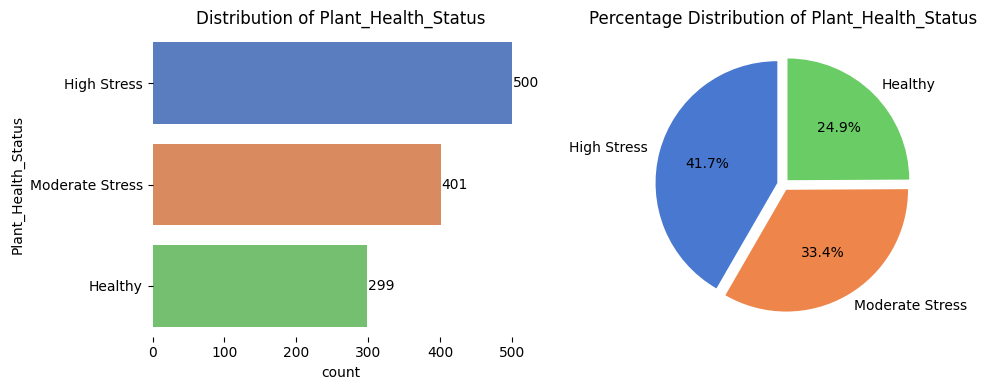

In [80]:
column_name = 'Plant_Health_Status'
plt.figure(figsize=(10, 4))

# First subplot: Count plot
plt.subplot(1, 2, 1)
sns.countplot(y=column_name, data=df, palette='muted')
plt.title(f'Distribution of {column_name}')

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='center', va='center', xytext=(10, 0), textcoords='offset points')

sns.despine(left=True, bottom=True)

# Second subplot: Pie chart
plt.subplot(1, 2, 2)
df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'), startangle=90, explode=[0.05]*df[column_name].nunique())
plt.title(f'Percentage Distribution of {column_name}')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [81]:
# Find the earliest and latest timestamps
start_date = pd.to_datetime(df['Timestamp']).min()
end_date = pd.to_datetime(df['Timestamp']).max()

print("Start Date:", start_date)
print("End Date:", end_date)

Start Date: 2024-10-03 10:54:53.407995
End Date: 2024-11-02 04:54:53.493508


In [82]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Check time differences between consecutive entries
time_diffs = df['Timestamp'].diff().value_counts()

print("Most common time differences:")
print(time_diffs.head(10))

Most common time differences:
Timestamp
0 days 06:00:00              1190
-30 days +06:00:00.005996       2
-30 days +06:00:00.008994       2
-30 days +06:00:00.006996       2
-30 days +06:00:00.018556       1
-30 days +06:00:00.012991       1
-30 days +06:00:00.009994       1
Name: count, dtype: int64


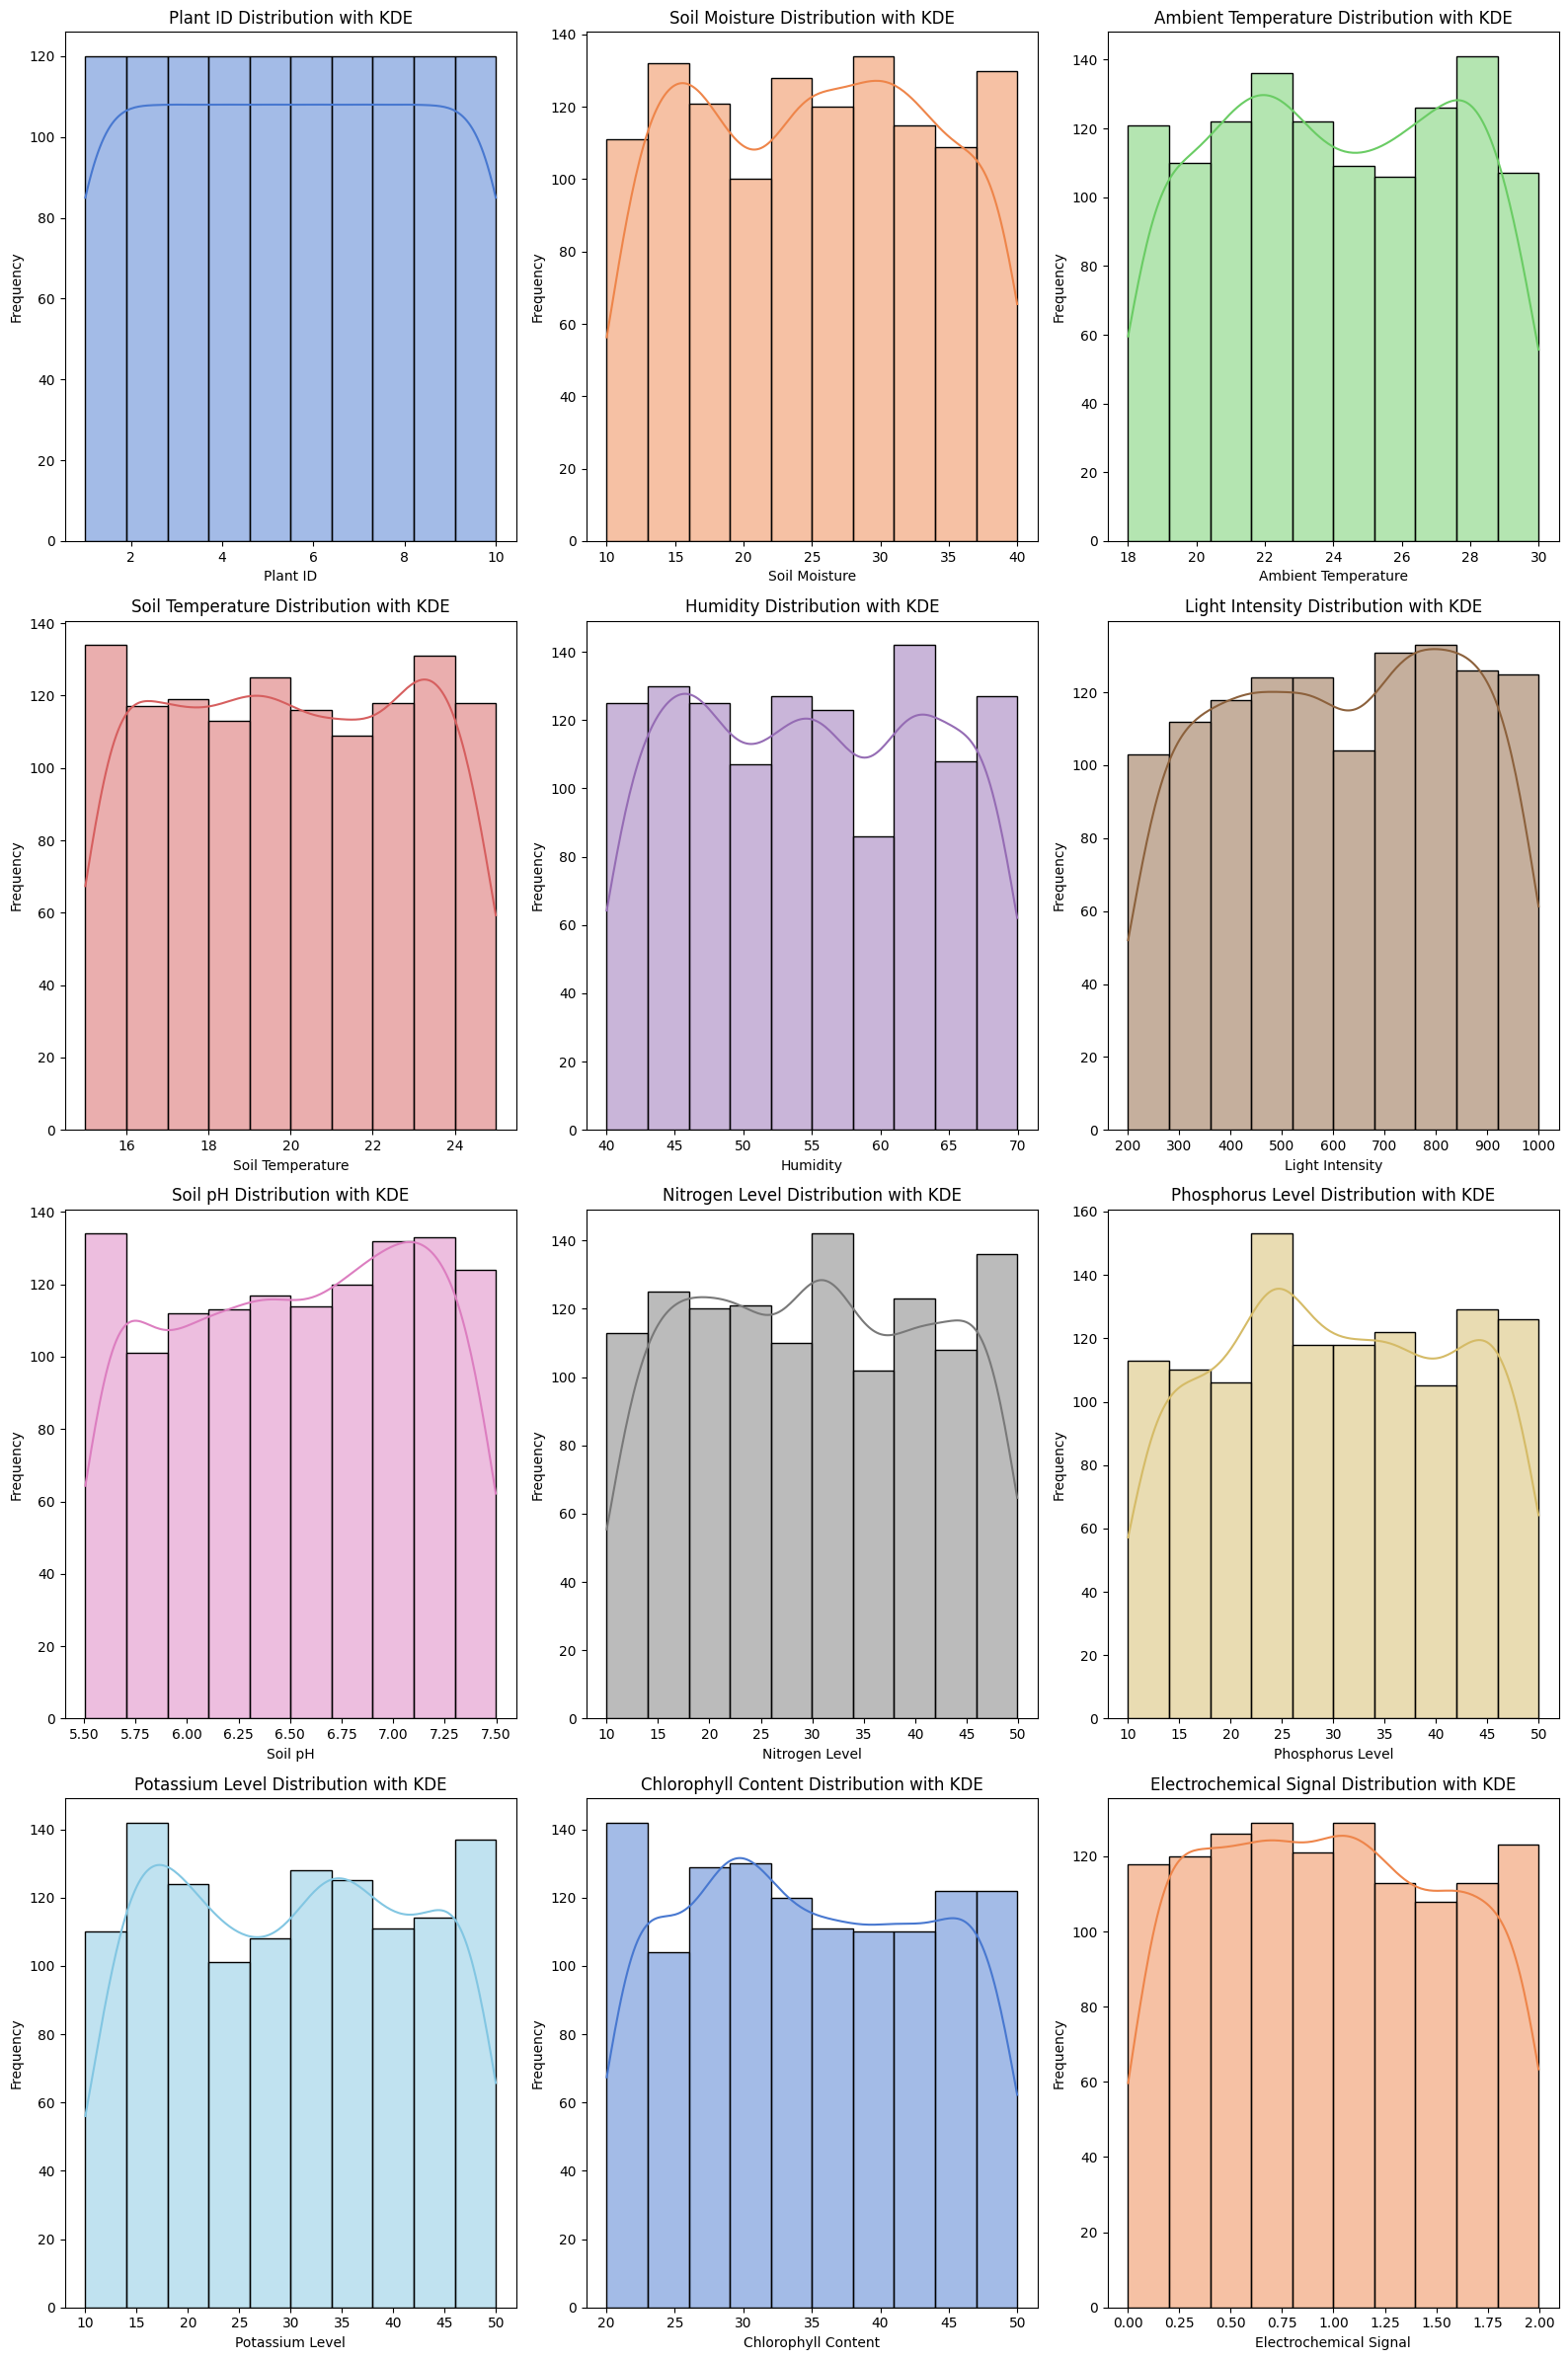

In [83]:
# Function to perform univariate analysis for numeric columns
def univariate_analysis(data, columns):
    plt.figure(figsize=(16, 24))  # Adjusted to accommodate more plots

    muted_colors = sns.color_palette("muted", len(columns))

    for i, column in enumerate(columns):
        plt.subplot(4, 3, i + 1)
        sns.histplot(data[column], kde=True, bins=10, color=muted_colors[i])
        plt.title(f'{column.replace("_", " ")} Distribution with KDE')
        plt.xlabel(column.replace('_', ' '))
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

columns_to_analyze = [
    'Plant_ID', 'Soil_Moisture', 'Ambient_Temperature', 'Soil_Temperature',
    'Humidity', 'Light_Intensity', 'Soil_pH', 'Nitrogen_Level',
    'Phosphorus_Level', 'Potassium_Level', 'Chlorophyll_Content',
    'Electrochemical_Signal'
]

# Perform univariate analysis
univariate_analysis(df, columns_to_analyze)

In [84]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=[np.number])

# Calculate skewness and kurtosis
skewness = numerical_df.skew()
kurtosis = numerical_df.kurt()

display("Skewness:", skewness)
print("\n")
display("Kurtosis:", kurtosis)

'Skewness:'

Plant_ID                  0.000000
Soil_Moisture             0.000928
Ambient_Temperature      -0.006935
Soil_Temperature          0.001161
Humidity                  0.021868
Light_Intensity          -0.064399
Soil_pH                  -0.084956
Nitrogen_Level            0.022234
Phosphorus_Level          0.001355
Potassium_Level           0.009818
Chlorophyll_Content       0.052388
Electrochemical_Signal    0.058807
dtype: float64

'Kurtosis:'

Plant_ID                 -1.224342
Soil_Moisture            -1.196111
Ambient_Temperature      -1.201252
Soil_Temperature         -1.228875
Humidity                 -1.238451
Light_Intensity          -1.195560
Soil_pH                  -1.215888
Nitrogen_Level           -1.195051
Phosphorus_Level         -1.156631
Potassium_Level          -1.234812
Chlorophyll_Content      -1.197901
Electrochemical_Signal   -1.170058
dtype: float64

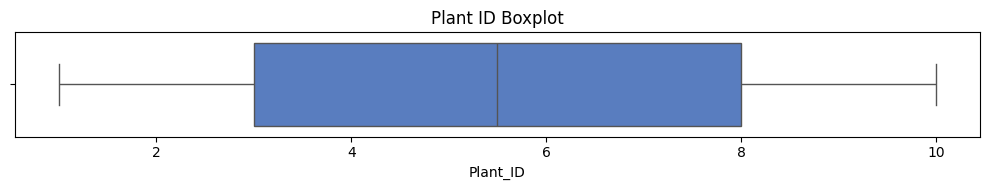


Summary Statistics for Plant ID:
 count    1200.000000
mean        5.500000
std         2.873479
min         1.000000
25%         3.000000
50%         5.500000
75%         8.000000
max        10.000000
Name: Plant_ID, dtype: float64


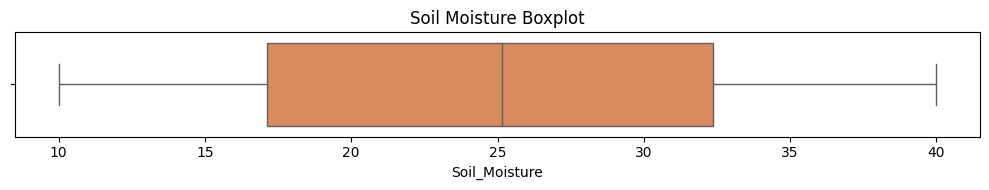


Summary Statistics for Soil Moisture:
 count    1200.000000
mean       25.106918
std         8.677725
min        10.000724
25%        17.131893
50%        25.168333
75%        32.370231
max        39.993164
Name: Soil_Moisture, dtype: float64


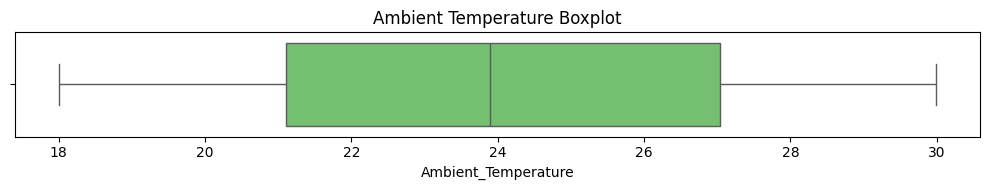


Summary Statistics for Ambient Temperature:
 count    1200.000000
mean       23.999130
std         3.441561
min        18.001993
25%        21.101766
50%        23.889044
75%        27.042634
max        29.990886
Name: Ambient_Temperature, dtype: float64


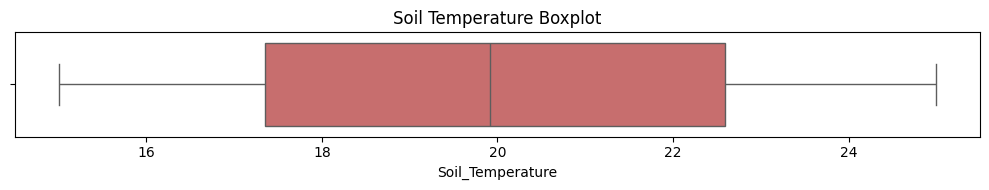


Summary Statistics for Soil Temperature:
 count    1200.000000
mean       19.957794
std         2.932073
min        15.003710
25%        17.353027
50%        19.911473
75%        22.596851
max        24.995929
Name: Soil_Temperature, dtype: float64


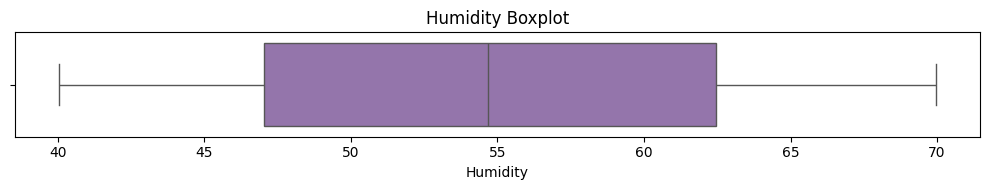


Summary Statistics for Humidity:
 count    1200.000000
mean       54.853165
std         8.784916
min        40.028758
25%        47.019694
50%        54.692069
75%        62.451053
max        69.968871
Name: Humidity, dtype: float64


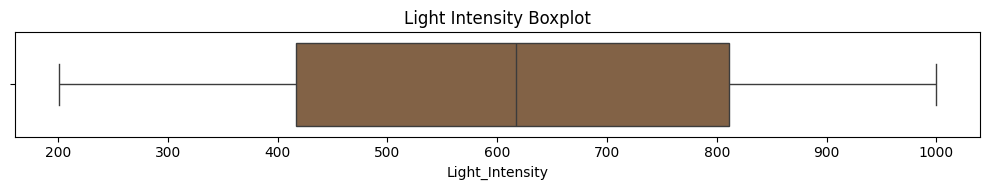


Summary Statistics for Light Intensity:
 count    1200.000000
mean      612.637265
std       228.318853
min       200.615482
25%       416.878983
50%       617.240221
75%       811.474690
max       999.856262
Name: Light_Intensity, dtype: float64


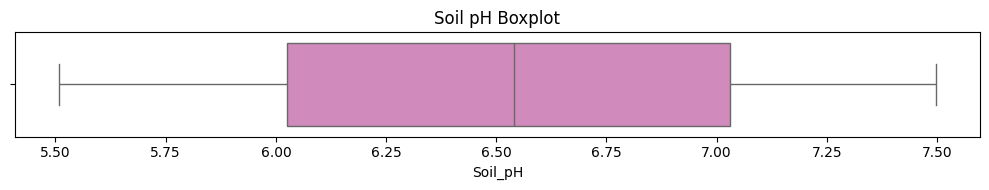


Summary Statistics for Soil pH:
 count    1200.000000
mean        6.524102
std         0.581755
min         5.507392
25%         6.026042
50%         6.540524
75%         7.030039
max         7.497823
Name: Soil_pH, dtype: float64


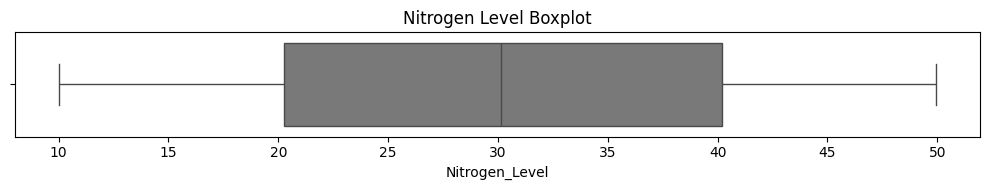


Summary Statistics for Nitrogen Level:
 count    1200.000000
mean       30.106751
std        11.514396
min        10.003650
25%        20.249774
50%        30.138590
75%        40.184737
max        49.951136
Name: Nitrogen_Level, dtype: float64


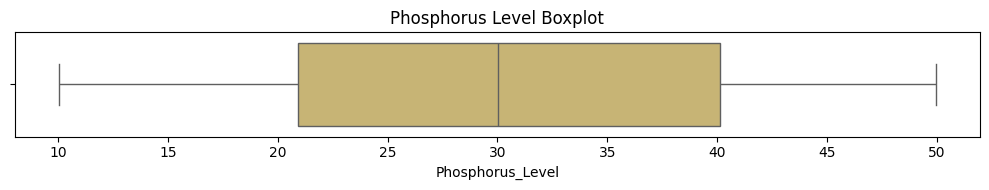


Summary Statistics for Phosphorus Level:
 count    1200.000000
mean       30.264484
std        11.466846
min        10.017690
25%        20.894445
50%        30.019385
75%        40.131459
max        49.980700
Name: Phosphorus_Level, dtype: float64


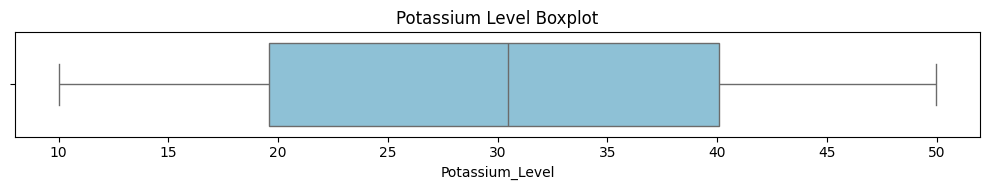


Summary Statistics for Potassium Level:
 count    1200.000000
mean       30.112088
std        11.668085
min        10.000606
25%        19.585561
50%        30.495054
75%        40.108296
max        49.981945
Name: Potassium_Level, dtype: float64


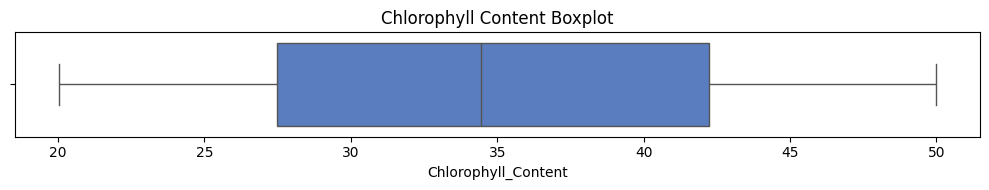


Summary Statistics for Chlorophyll Content:
 count    1200.000000
mean       34.749591
std         8.766995
min        20.025511
25%        27.463350
50%        34.433427
75%        42.232637
max        49.990811
Name: Chlorophyll_Content, dtype: float64


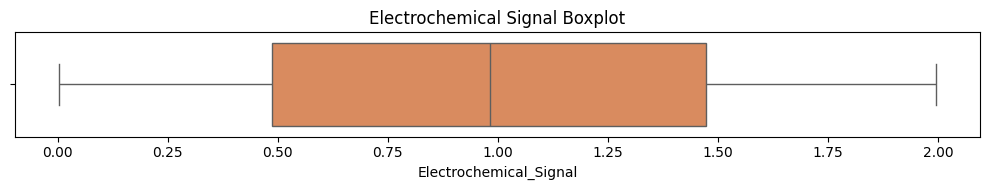


Summary Statistics for Electrochemical Signal:
 count    1200.000000
mean        0.987764
std         0.575116
min         0.002376
25%         0.487982
50%         0.981647
75%         1.473142
max         1.996116
Name: Electrochemical_Signal, dtype: float64


In [85]:
# Function to perform univariate analysis for numeric columns with boxplots and statistics
def univariate_analysis(data, column, title):
    plt.figure(figsize=(10, 2))

    color = sns.color_palette("muted")[columns_to_analyze.index(column) % len(sns.color_palette("muted"))]

    sns.boxplot(x=data[column], color=color)
    plt.title(f'{title} Boxplot')

    plt.tight_layout()
    plt.show()

    print(f'\nSummary Statistics for {title}:\n', data[column].describe())

columns_to_analyze = [
    'Plant_ID', 'Soil_Moisture', 'Ambient_Temperature', 'Soil_Temperature',
    'Humidity', 'Light_Intensity', 'Soil_pH', 'Nitrogen_Level',
    'Phosphorus_Level', 'Potassium_Level', 'Chlorophyll_Content',
    'Electrochemical_Signal'
]

# Iterate through columns and perform univariate analysis
for column in columns_to_analyze:
    univariate_analysis(df, column, column.replace('_', ' '))

In [86]:
# Convert the Timestamp column to datetime format if not already
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Create a 'Week' column to group by week
df['Week'] = df['Timestamp'].dt.to_period('W').apply(lambda r: r.start_time)

# Aggregate Plant Health Status weekly for each Plant ID
weekly_health_status = (
    df.groupby(['Plant_ID', 'Week', 'Plant_Health_Status'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

weekly_health_status.columns.name = None
weekly_health_status = weekly_health_status.rename(columns={
    'High Stress': 'High_Stress_Count',
    'Moderate Stress': 'Moderate_Stress_Count',
    'Healthy': 'Healthy_Count'
})

weekly_health_status

Plant_ID       Week  Healthy_Count  High_Stress_Count  \
0          1 2024-09-30              1                  9   
1          1 2024-10-07             10                 12   
2          1 2024-10-14              2                 15   
3          1 2024-10-21              4                  8   
4          1 2024-10-28              7                  6   
5          2 2024-09-30              2                  7   
6          2 2024-10-07             12                 10   
7          2 2024-10-14              7                 12   
8          2 2024-10-21              9                 13   
9          2 2024-10-28              6                 11   
10         3 2024-09-30              6                  2   
11         3 2024-10-07              6                  8   
12         3 2024-10-14             10                 11   
13         3 2024-10-21              8                 12   
14         3 2024-10-28              9                  8   
15         4 2024-09-30              4                  3   
16         4 2024-10-07              8                 10   
17         4 2024-10-14             10                 12   
18         4 2024-10-21              4                 12   
19         4 2024-10-28              2                  9   
20         5 2024-09-30              2                  5   
21         5 2024-10-07              8                 11   
22         5 2024-10-14              5                 12   
23         5 2024-10-21             11                  9   
24         5 2024-10-28              3                 13   
25         6 2024-09-30              5                  3   
26         6 2024-10-07              6                 15   
27         6 2024-10-14              7                 11   
28         6 2024-10-21              4                 14   
29         6 2024-10-28              7                  3   
30         7 2024-09-30              3                  5   
31         7 2024-10-07             13                 11   
32         7 2024-10-14              7                 12   
33         7 2024-10-21              5                 17   
34         7 2024-10-28              2                 10   
35         8 2024-09-30              3                  8   
36         8 2024-10-07             10                 10   
37         8 2024-10-14              7                 10   
38         8 2024-10-21              4                 16   
39         8 2024-10-28              4                  8   
40         9 2024-09-30              4                  8   
41         9 2024-10-07              5                 15   
42         9 2024-10-14              6                 13   
43         9 2024-10-21              7                 13   
44         9 2024-10-28              6                  8   
45        10 2024-09-30              1                  7   
46        10 2024-10-07              6                 11   
47        10 2024-10-14              7                 14   
48        10 2024-10-21              7                 12   
49        10 2024-10-28              7                  6   

    Moderate_Stress_Count  
0                       5  
1                       6  
2                      11  
3                      16  
4                       8  
5                       6  
6                       6  
7                       9  
8                       6  
9                       4  
10                      7  
11                     14  
12                      7  
13                      8  
14                      4  
15                      8  
16                     10  
17                      6  
18                     12  
19                     10  
20                      8  
21                      9  
22                     11  
23                      8  
24                      5  
25                      7  
26                      7  
27                     10  
28                     10  
29                     11  
30                      

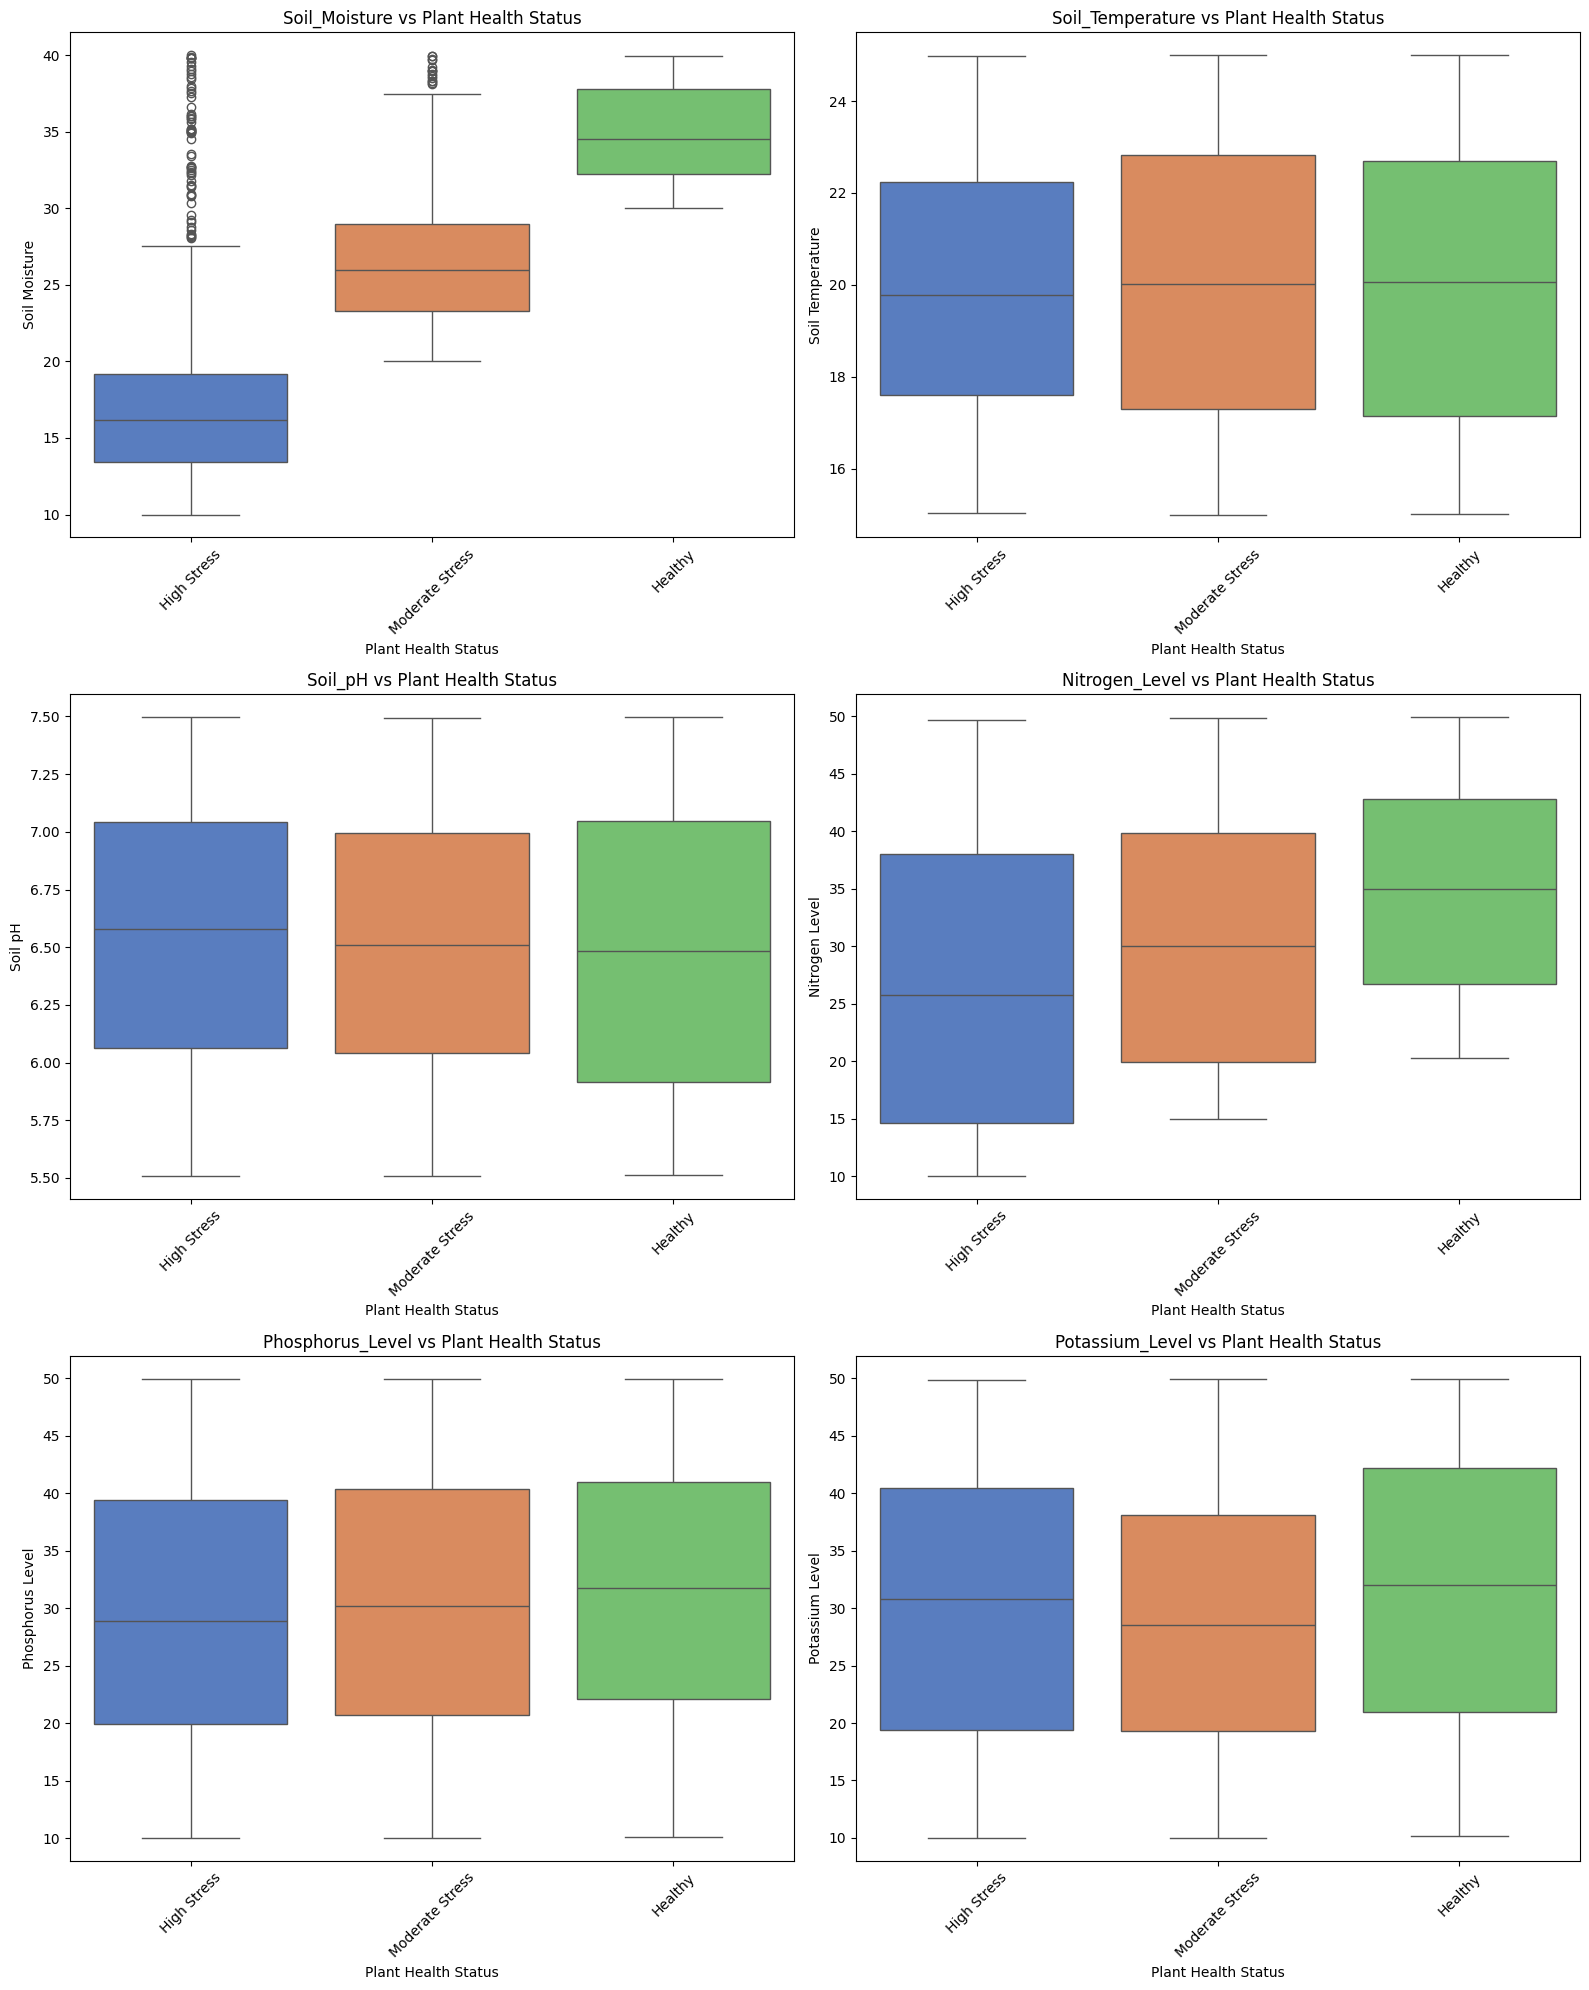

In [87]:
# Compare Plant_Health_Status with Soil Properties
# Define soil properties
soil_properties = [
    'Soil_Moisture', 'Soil_Temperature', 'Soil_pH',
    'Nitrogen_Level', 'Phosphorus_Level', 'Potassium_Level'
]

# Create subplots to visualize the relationship between Plant_Health_Status and soil properties
plt.figure(figsize=(16, 20))
for i, feature in enumerate(soil_properties):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x='Plant_Health_Status', y=feature, data=df, palette='muted')
    plt.title(f'{feature} vs Plant Health Status')
    plt.xlabel('Plant Health Status')
    plt.ylabel(feature.replace('_', ' '))
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

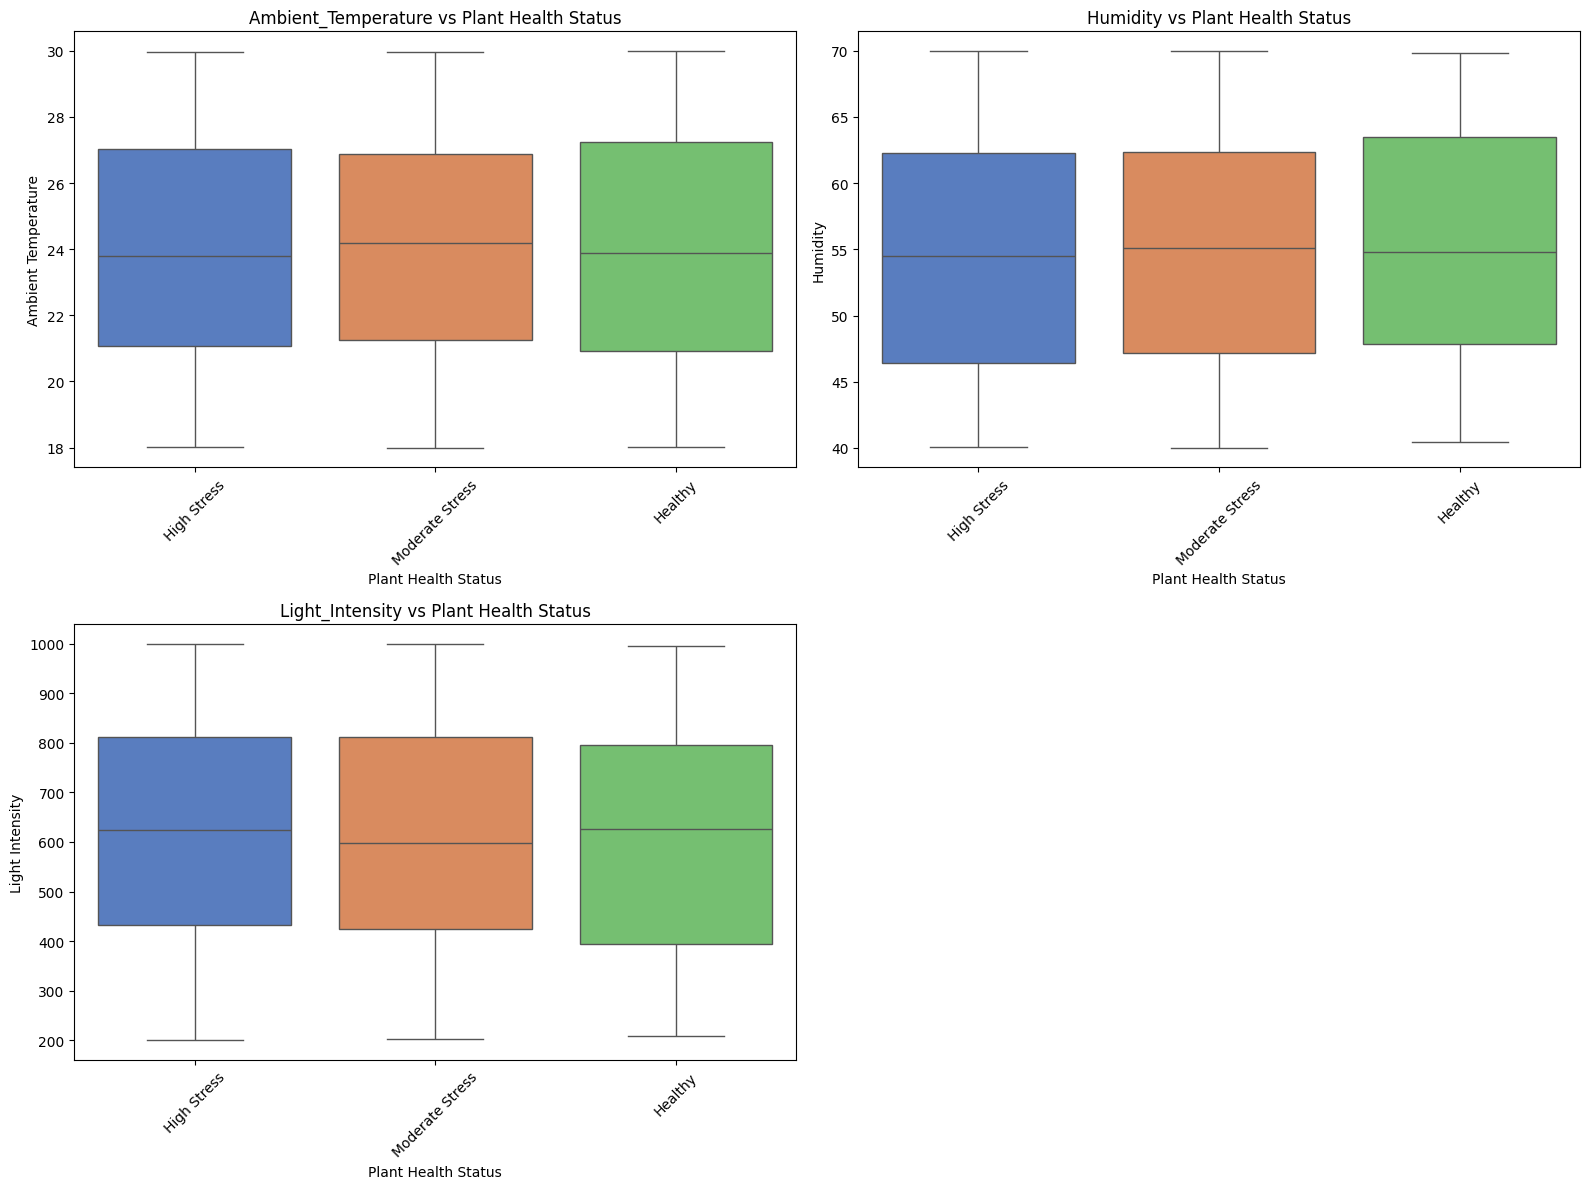

In [88]:
# Compare Plant_Health_Status with Environmental Conditions
# Define environmental condition features
environmental_conditions = [
    'Ambient_Temperature', 'Humidity', 'Light_Intensity'
]

# Create subplots to visualize the relationship between Plant_Health_Status and environmental conditions
plt.figure(figsize=(16, 12))
for i, feature in enumerate(environmental_conditions):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='Plant_Health_Status', y=feature, data=df, palette='muted')
    plt.title(f'{feature} vs Plant Health Status')
    plt.xlabel('Plant Health Status')
    plt.ylabel(feature.replace('_', ' '))
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

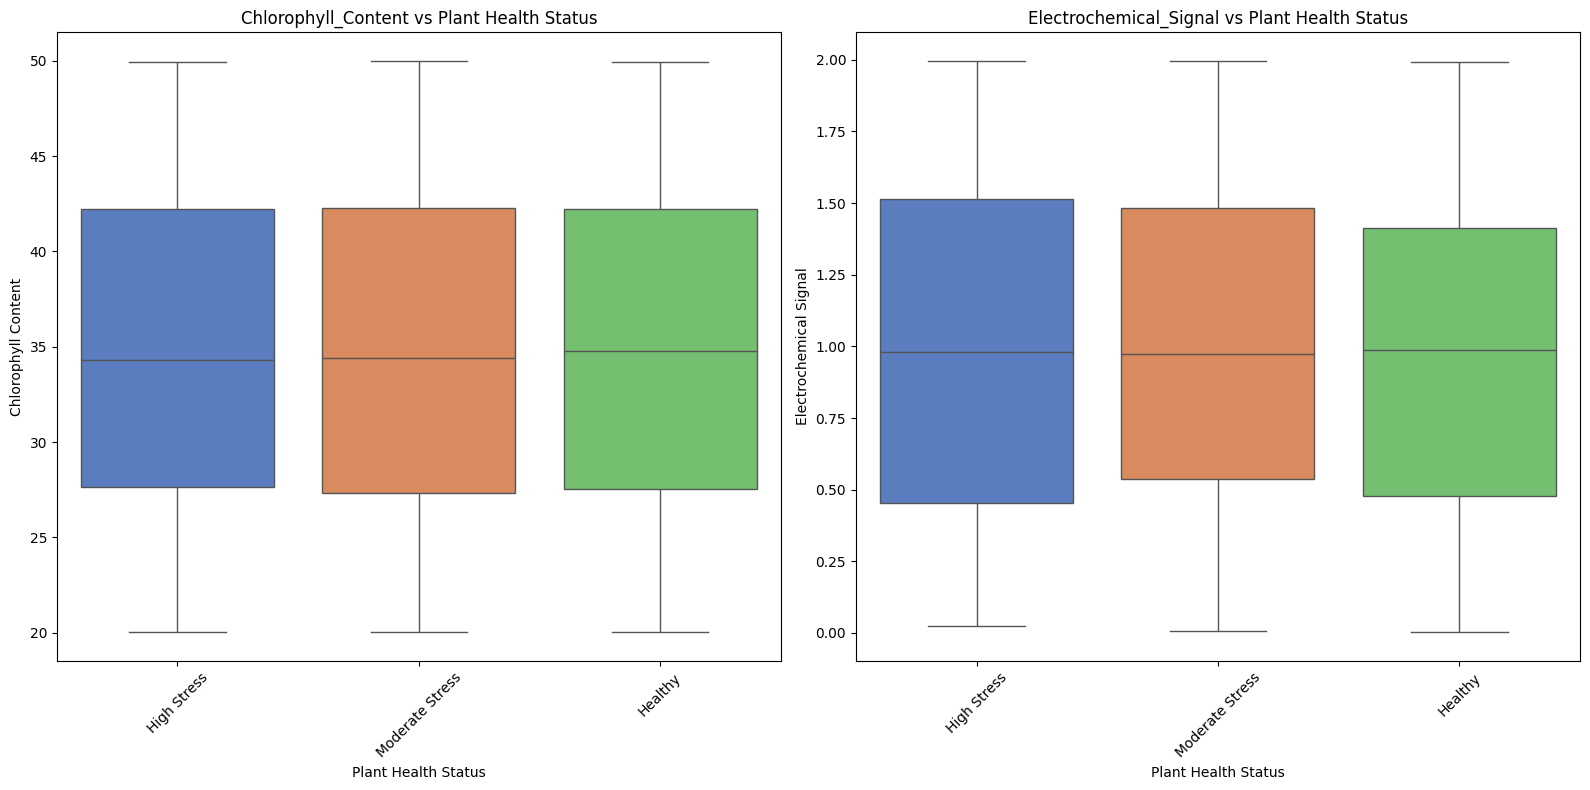

In [89]:
# Compare Plant_Health_Status with Plant Health Indicators

# Define plant health indicator features
health_indicators = [
    'Chlorophyll_Content', 'Electrochemical_Signal'
]

# Create subplots to visualize the relationship between Plant_Health_Status and plant health indicators
plt.figure(figsize=(16, 8))
for i, feature in enumerate(health_indicators):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(x='Plant_Health_Status', y=feature, data=df, palette='muted')
    plt.title(f'{feature} vs Plant Health Status')
    plt.xlabel('Plant Health Status')
    plt.ylabel(feature.replace('_', ' '))
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

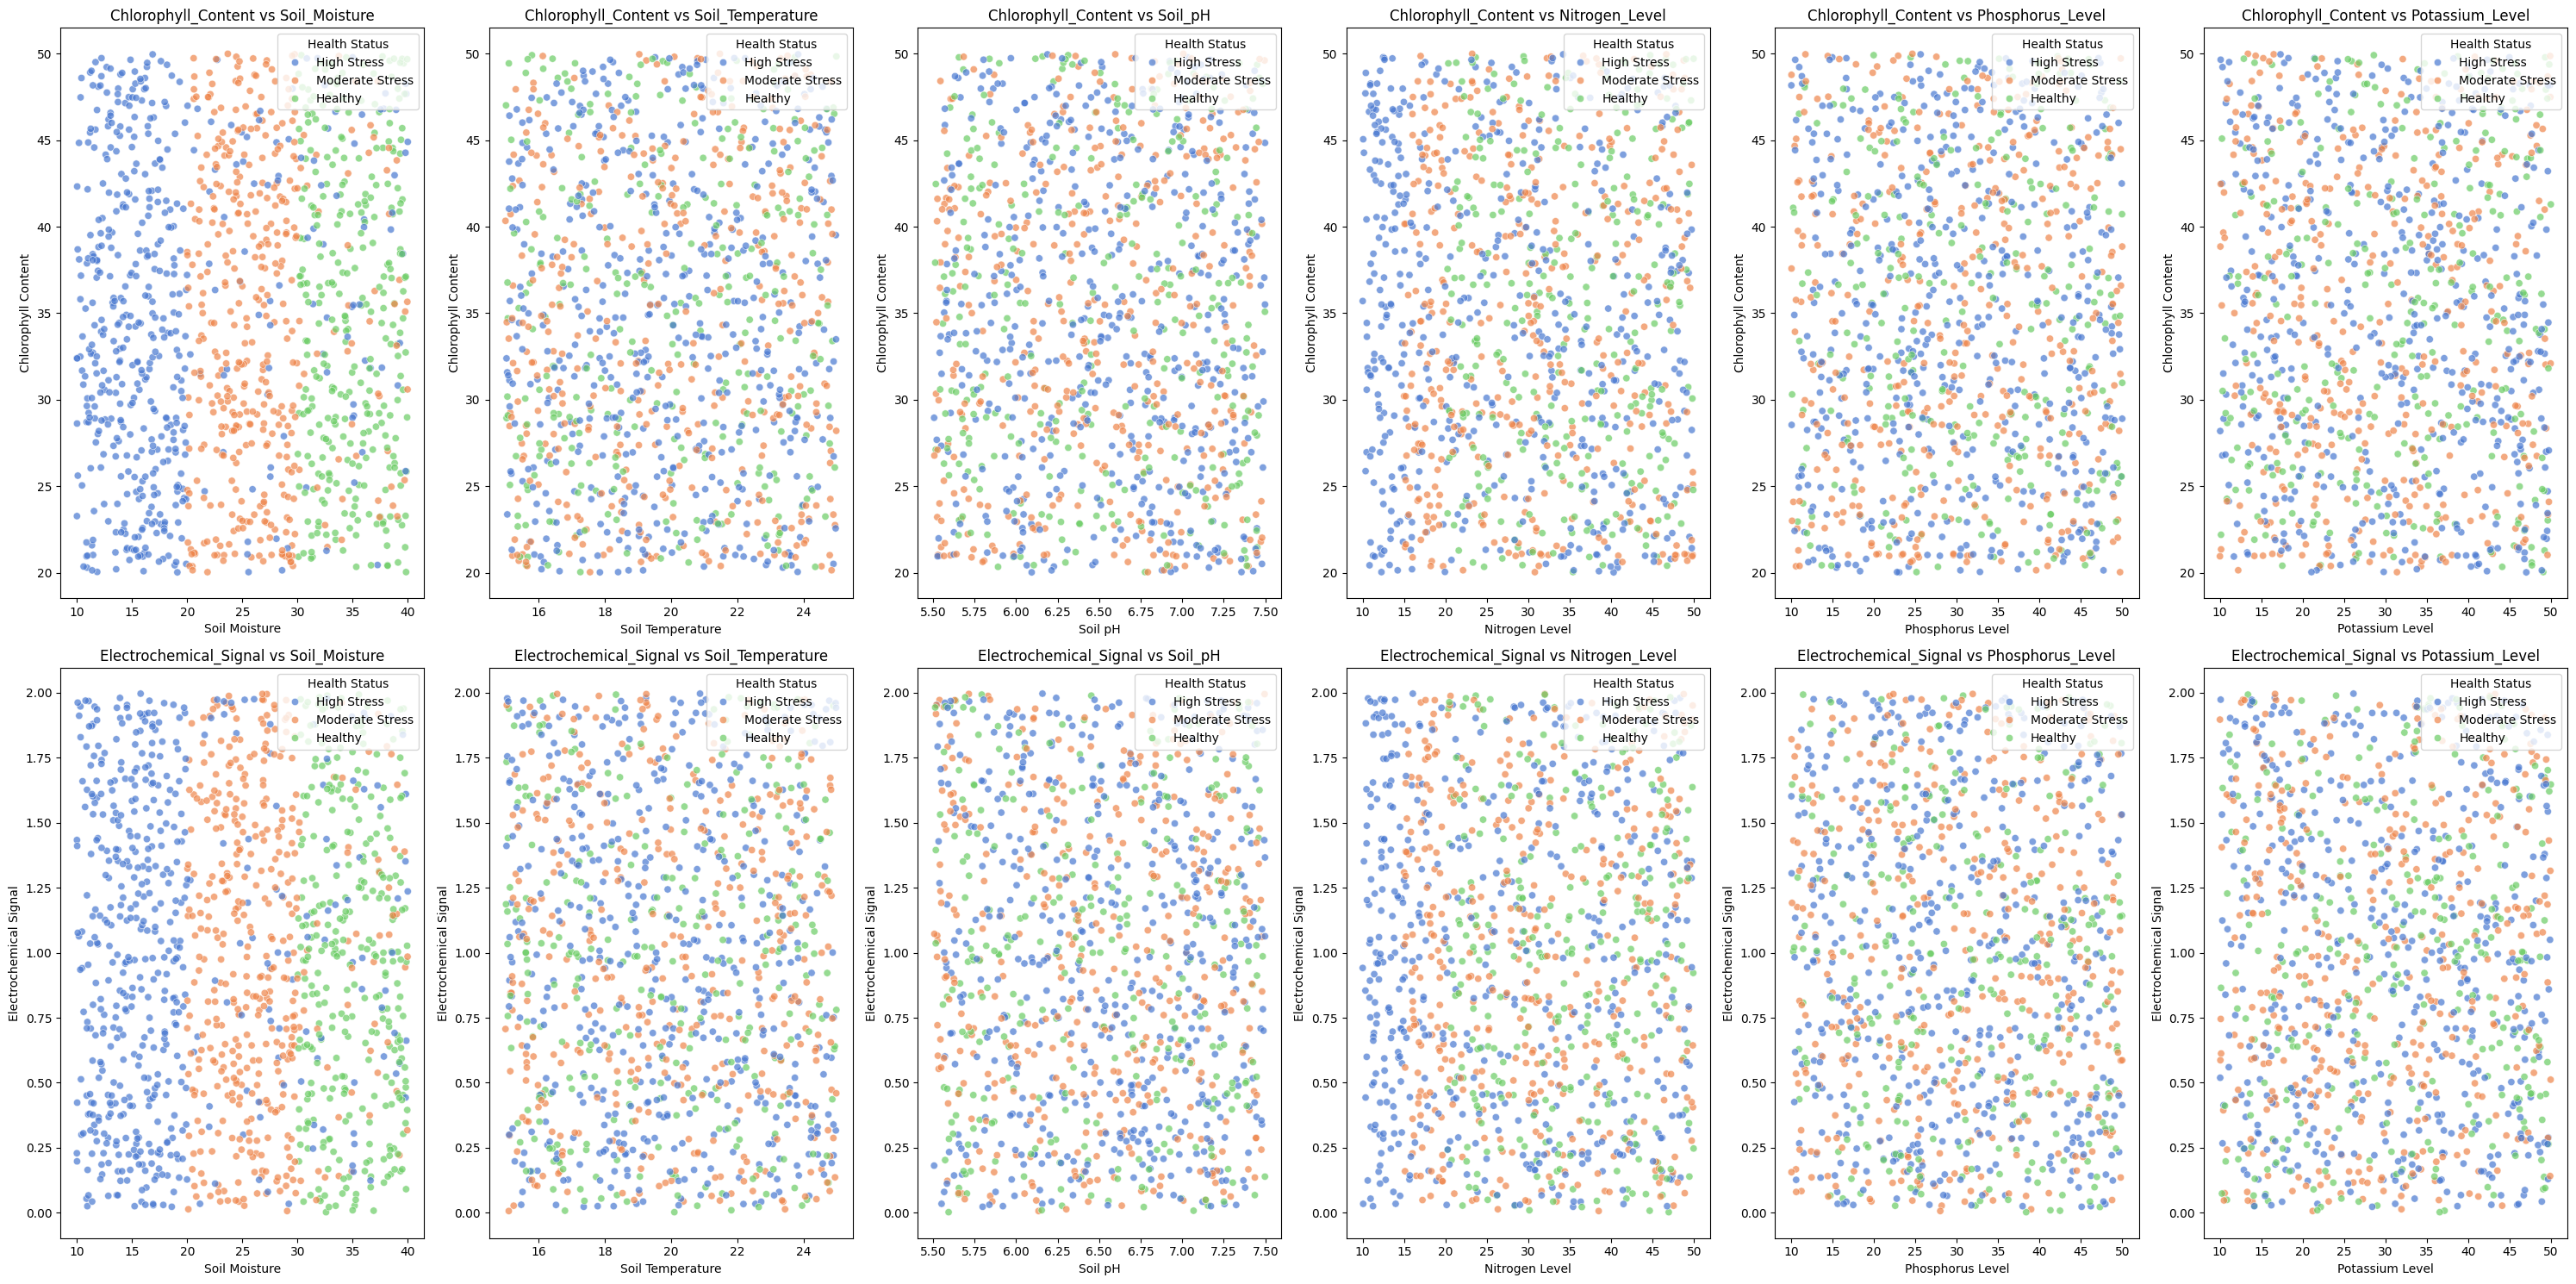

In [90]:
# Compare Plant_Health_Status with Plant Health Indicators vs Soil Properties using scatter plots

# Define soil properties and plant health indicators
soil_properties = [
    'Soil_Moisture', 'Soil_Temperature', 'Soil_pH',
    'Nitrogen_Level', 'Phosphorus_Level', 'Potassium_Level'
]

health_indicators = [
    'Chlorophyll_Content', 'Electrochemical_Signal'
]

# Create scatter plots for each combination of plant health indicators and soil properties
plt.figure(figsize=(30, 15))
plot_index = 1

for health_indicator in health_indicators:
    for soil_property in soil_properties:
        plt.subplot(len(health_indicators), len(soil_properties), plot_index)
        sns.scatterplot(
            x=soil_property,
            y=health_indicator,
            hue='Plant_Health_Status',
            data=df,
            palette='muted',
            alpha=0.7
        )
        plt.title(f'{health_indicator} vs {soil_property}')
        plt.xlabel(soil_property.replace('_', ' '))
        plt.ylabel(health_indicator.replace('_', ' '))
        plt.legend(title='Health Status', loc='upper right')
        plot_index += 1

plt.tight_layout()
plt.show()

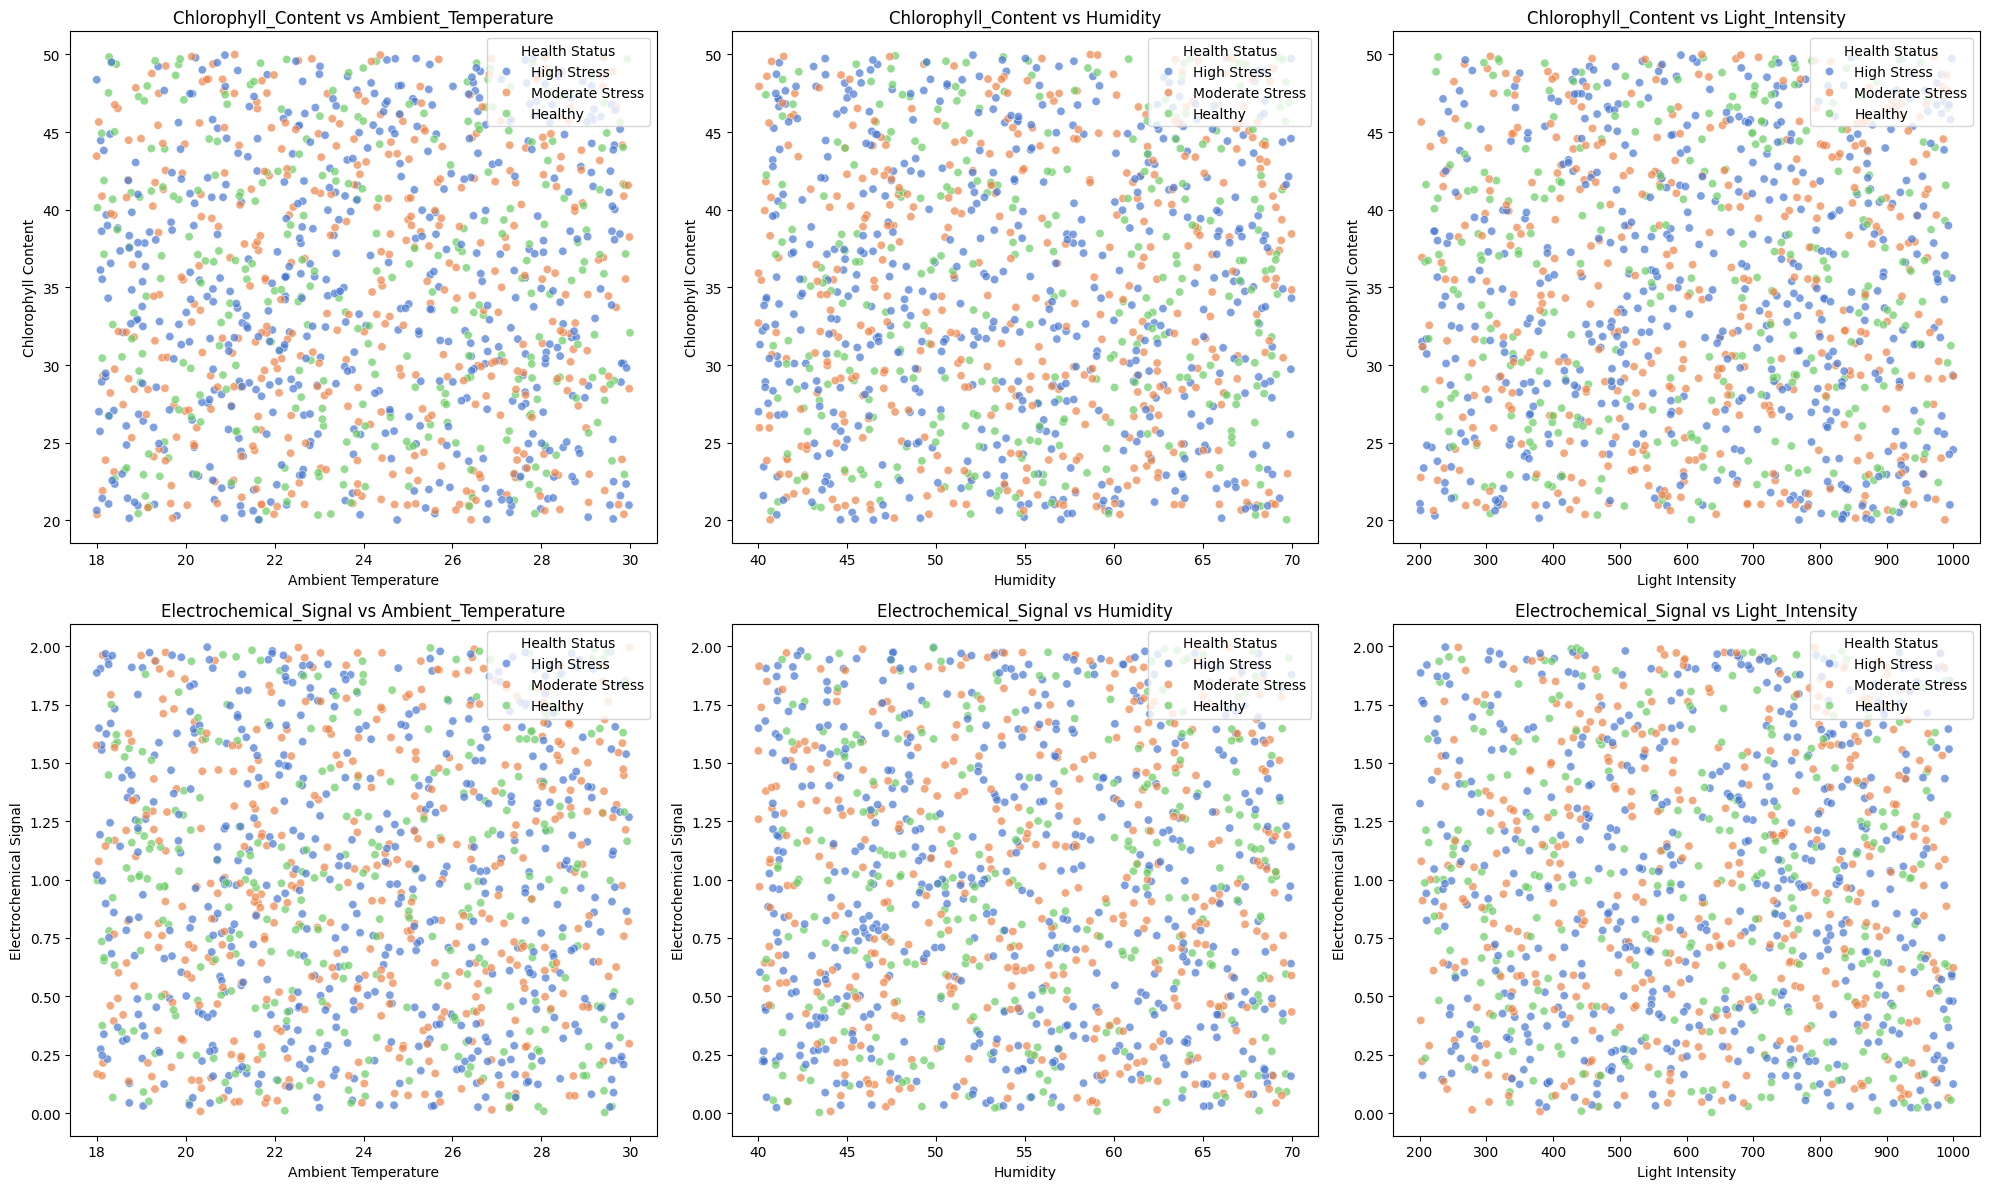

In [91]:
# Compare Plant_Health_Status with Plant Health Indicators vs Environmental Conditions using scatter plots

# Define environmental conditions and plant health indicators
environmental_conditions = [
    'Ambient_Temperature', 'Humidity', 'Light_Intensity'
]

health_indicators = [
    'Chlorophyll_Content', 'Electrochemical_Signal'
]

# Create scatter plots for each combination of plant health indicators and environmental conditions
plt.figure(figsize=(20, 12))
plot_index = 1

for health_indicator in health_indicators:
    for env_condition in environmental_conditions:
        plt.subplot(len(health_indicators), len(environmental_conditions), plot_index)
        sns.scatterplot(
            x=env_condition,
            y=health_indicator,
            hue='Plant_Health_Status',
            data=df,
            palette='muted',
            alpha=0.7
        )
        plt.title(f'{health_indicator} vs {env_condition}')
        plt.xlabel(env_condition.replace('_', ' '))
        plt.ylabel(health_indicator.replace('_', ' '))
        plt.legend(title='Health Status', loc='upper right')
        plot_index += 1

plt.tight_layout()
plt.show()

In [92]:
# Calculate mean nutrient levels by Plant ID and Plant Health Status
nutrient_status_mean = df.groupby(['Plant_ID', 'Plant_Health_Status'])[
    ['Nitrogen_Level', 'Phosphorus_Level', 'Potassium_Level']
].mean().reset_index()

# Separate the nutrient status mean table into three based on Plant_Health_Status
nutrient_high_stress = nutrient_status_mean[nutrient_status_mean['Plant_Health_Status'] == 'High Stress']
nutrient_moderate_stress = nutrient_status_mean[nutrient_status_mean['Plant_Health_Status'] == 'Moderate Stress']
nutrient_healthy = nutrient_status_mean[nutrient_status_mean['Plant_Health_Status'] == 'Healthy']

# Display the three tables to the user
print("----- Nutrient Levels for High Stress Plants -----")
display(nutrient_high_stress)

print("\n----- Nutrient Levels for Moderate Stress Plants -----")
display(nutrient_moderate_stress)

print("\n----- Nutrient Levels for Healthy Plants -----")
display(nutrient_healthy)

----- Nutrient Levels for High Stress Plants -----


Plant_ID Plant_Health_Status  Nitrogen_Level  Phosphorus_Level  \
1          1         High Stress       25.782419         28.749032   
4          2         High Stress       25.632629         29.334914   
7          3         High Stress       29.238585         31.284210   
10         4         High Stress       28.592522         29.799930   
13         5         High Stress       29.099439         31.907226   
16         6         High Stress       28.311847         28.162508   
19         7         High Stress       25.426572         27.070109   
22         8         High Stress       26.034050         30.700334   
25         9         High Stress       24.441075         30.135068   
28        10         High Stress       28.431825         29.766865   

    Potassium_Level  
1         29.472459  
4         30.038894  
7         30.403602  
10        30.978085  
13        31.913175  
16        30.457481  
19        30.548976  
22        29.147110  
25        30.001101  
28        29.906171


----- Nutrient Levels for Moderate Stress Plants -----


Plant_ID Plant_Health_Status  Nitrogen_Level  Phosphorus_Level  \
2          1     Moderate Stress       30.195361         30.272306   
5          2     Moderate Stress       30.058320         28.154977   
8          3     Moderate Stress       33.702120         31.564693   
11         4     Moderate Stress       31.641916         29.941019   
14         5     Moderate Stress       29.016512         28.970409   
17         6     Moderate Stress       29.973616         31.448612   
20         7     Moderate Stress       30.666419         33.347397   
23         8     Moderate Stress       27.244773         29.770846   
26         9     Moderate Stress       30.596865         30.240188   
29        10     Moderate Stress       31.964593         27.982383   

    Potassium_Level  
2         27.734632  
5         26.682910  
8         29.639307  
11        29.387424  
14        27.670648  
17        30.427912  
20        30.820548  
23        30.689264  
26        27.853445  
29        29.422763


----- Nutrient Levels for Healthy Plants -----


Plant_ID Plant_Health_Status  Nitrogen_Level  Phosphorus_Level  \
0          1             Healthy       37.219617         30.091069   
3          2             Healthy       31.240088         33.537427   
6          3             Healthy       36.311837         31.078678   
9          4             Healthy       35.628793         29.229156   
12         5             Healthy       31.788659         34.739030   
15         6             Healthy       34.485720         33.420505   
18         7             Healthy       38.712097         27.308429   
21         8             Healthy       35.216426         32.874419   
24         9             Healthy       32.226382         29.810551   
27        10             Healthy       35.689817         31.380791   

    Potassium_Level  
0         28.714915  
3         30.042467  
6         33.969097  
9         31.694995  
12        29.822802  
15        32.946055  
18        30.428536  
21        32.760895  
24        28.315854  
27        32.574835

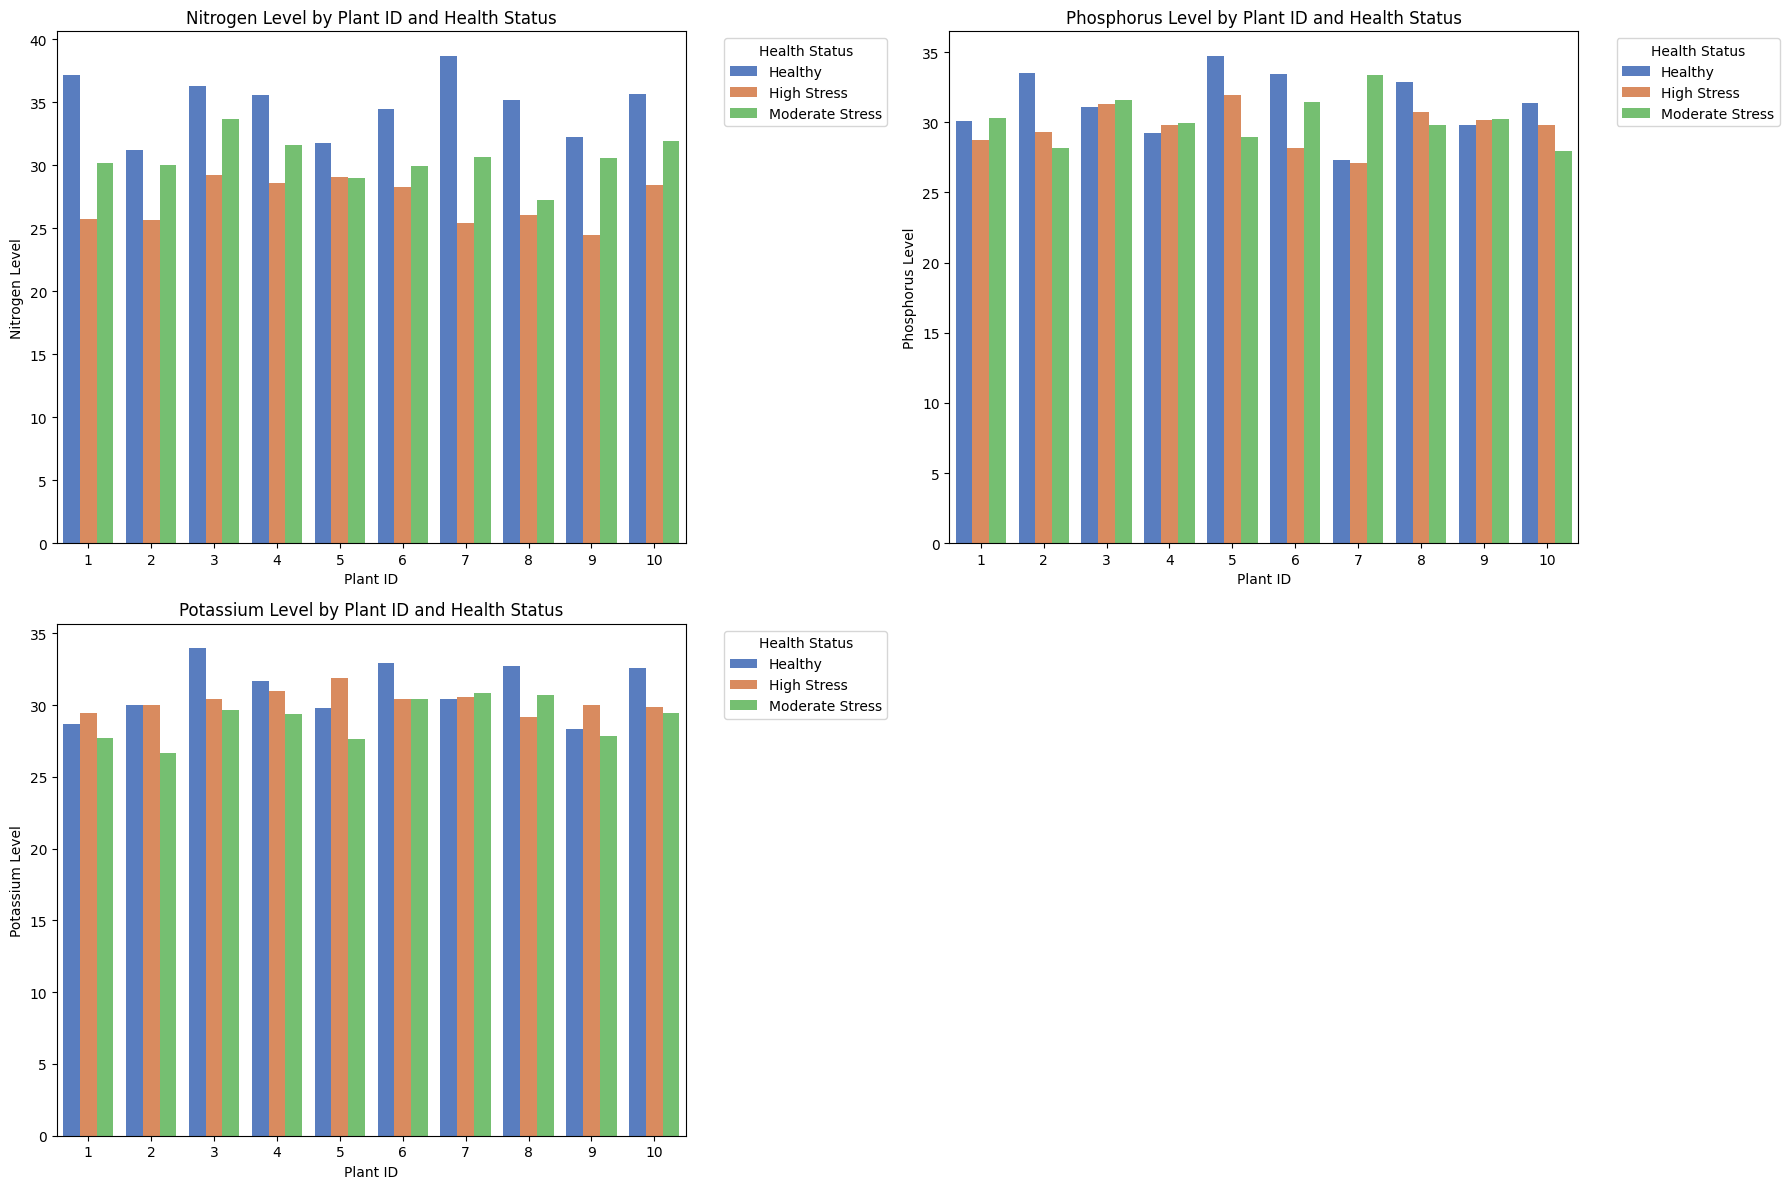

In [93]:
# Visualize the nutrient levels across different Plant_Health_Status categories (High Stress, Moderate Stress, Healthy) for each Plant_ID
# Define nutrient levels
nutrients = ['Nitrogen_Level', 'Phosphorus_Level', 'Potassium_Level']

# Set up the plot
plt.figure(figsize=(18, 12))
for i, nutrient in enumerate(nutrients):
    plt.subplot(2, 2, i + 1)
    sns.barplot(
        x='Plant_ID',
        y=nutrient,
        hue='Plant_Health_Status',
        data=nutrient_status_mean,
        palette='muted'
    )
    plt.title(f'{nutrient.replace("_", " ")} by Plant ID and Health Status')
    plt.xlabel('Plant ID')
    plt.ylabel(nutrient.replace('_', ' '))
    plt.legend(title='Health Status', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

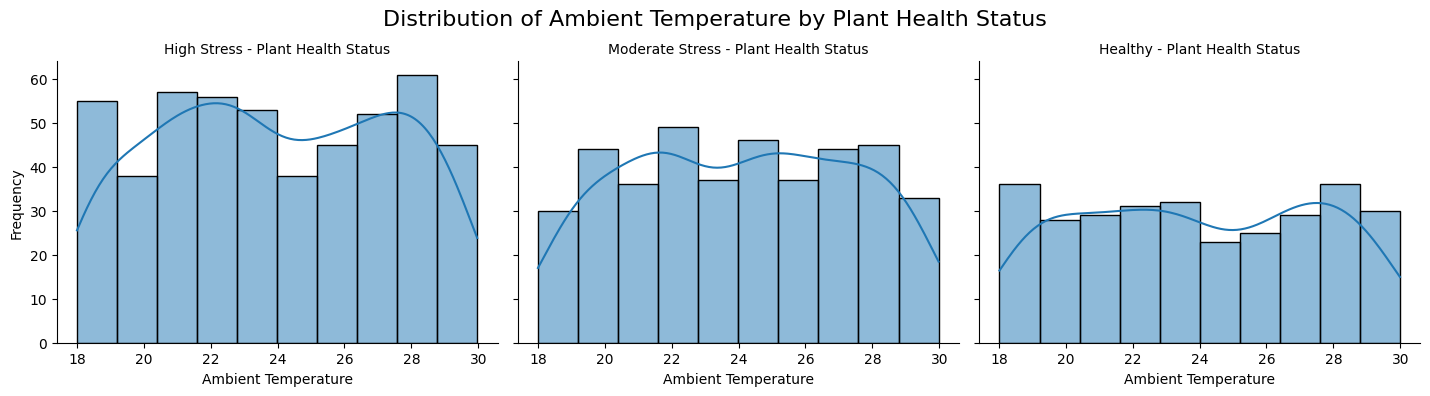

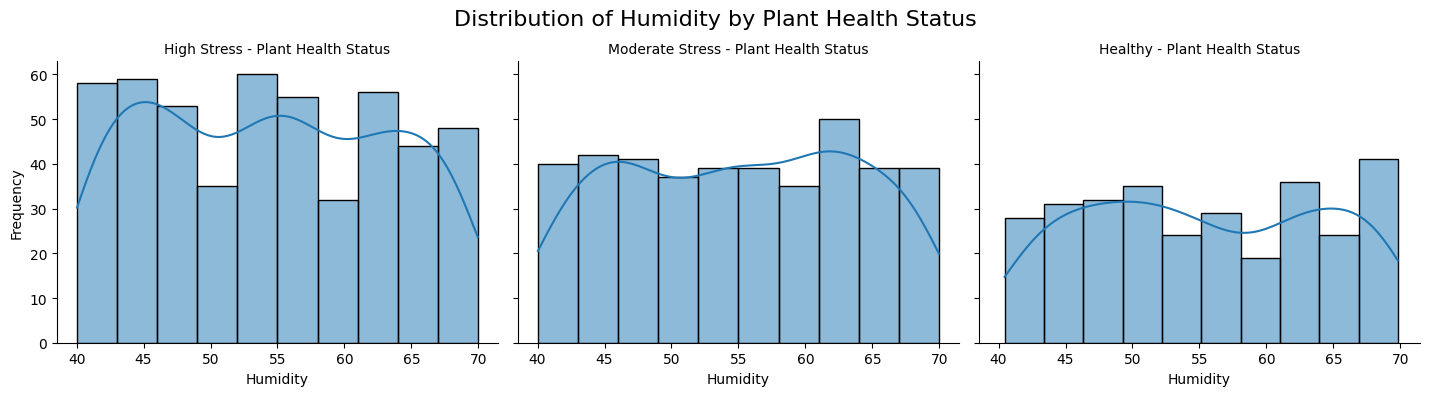

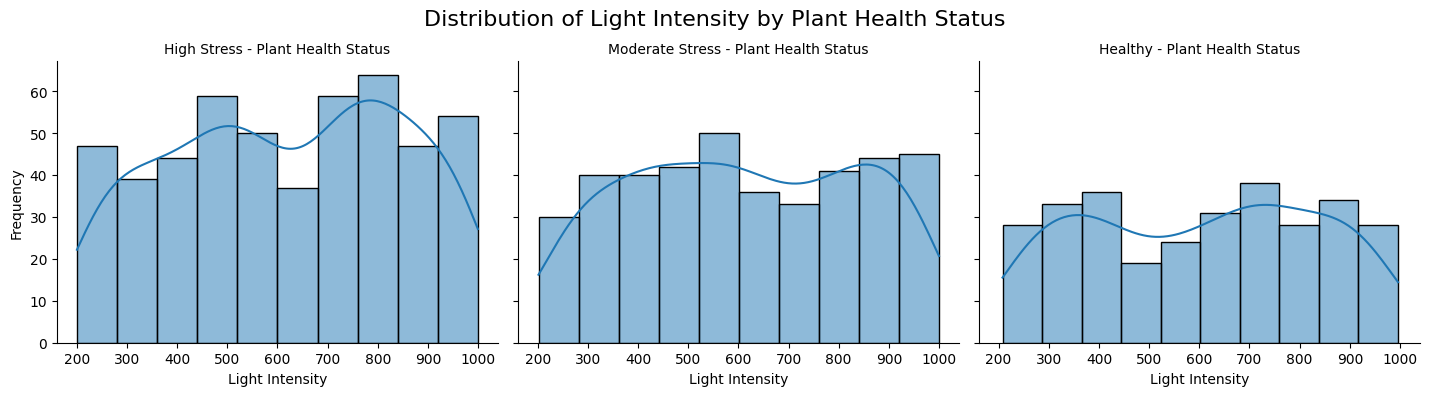

In [94]:
# Environmental Conditions vs Plant_Health_Status using FacetGrid with improved styling

# Define environmental conditions to plot
environmental_conditions = ['Ambient_Temperature', 'Humidity', 'Light_Intensity']

# Create FacetGrid plots for each environmental condition with improved styling
for condition in environmental_conditions:
    g = sns.FacetGrid(
        df,
        col='Plant_Health_Status',
        height=4,
        aspect=1.2,
        sharex=True,
        sharey=True,
    )
    g.map(sns.histplot, condition, kde=True, bins=10, color=None)
    g.set_axis_labels(condition.replace('_', ' '), 'Frequency')
    g.set_titles("{col_name} - Plant Health Status")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(
        f'Distribution of {condition.replace("_", " ")} by Plant Health Status',
        fontsize=16,
        y=0.98
    )
    plt.show()

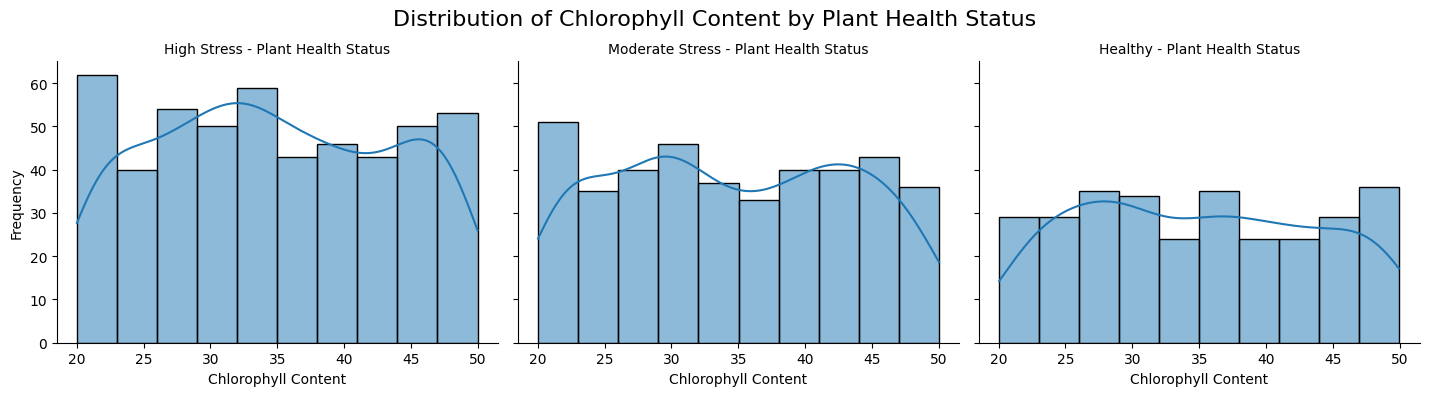

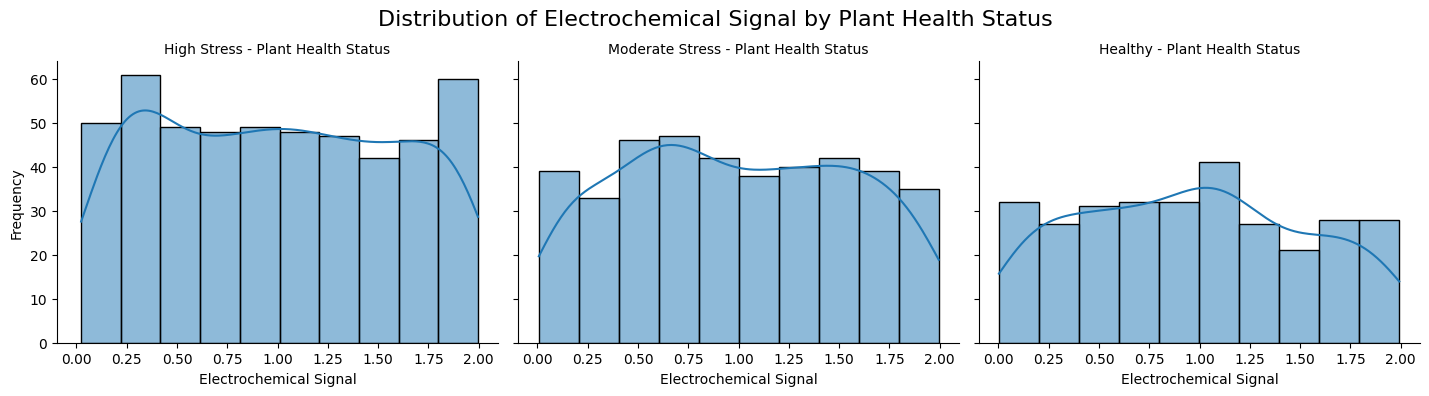

In [95]:
# Define plant health indicators to plot
health_indicators = ['Chlorophyll_Content', 'Electrochemical_Signal']

# Create FacetGrid plots for each health indicator
for indicator in health_indicators:
    g = sns.FacetGrid(
        df,
        col='Plant_Health_Status',
        height=4,
        aspect=1.2,
        sharex=True,
        sharey=True
    )
    g.map(sns.histplot, indicator, kde=True, bins=10, color=None)
    g.set_axis_labels(indicator.replace('_', ' '), 'Frequency')
    g.set_titles("{col_name} - Plant Health Status")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(
        f'Distribution of {indicator.replace("_", " ")} by Plant Health Status',
        fontsize=16,
        y=0.98
    )
    plt.show()

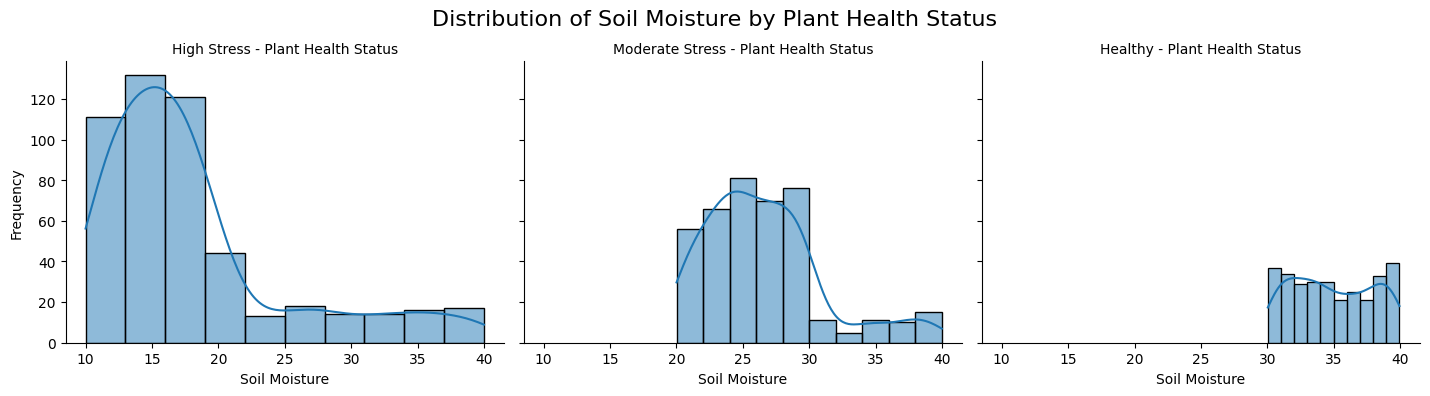

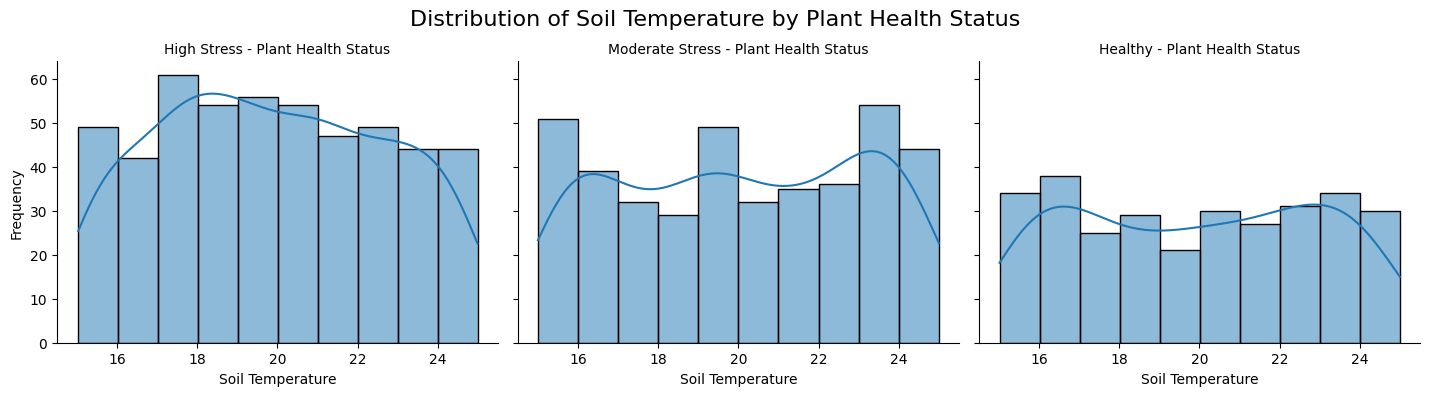

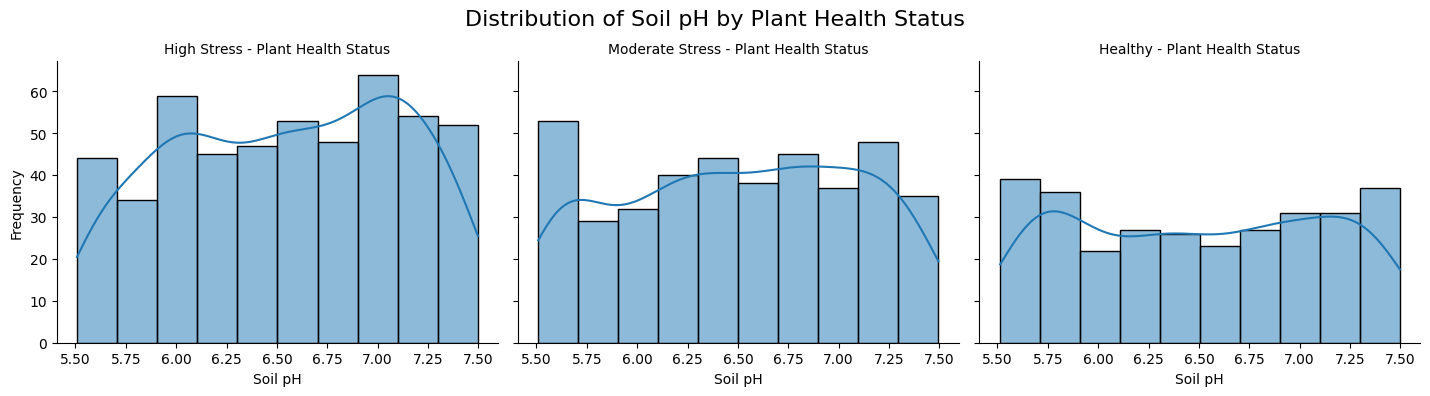

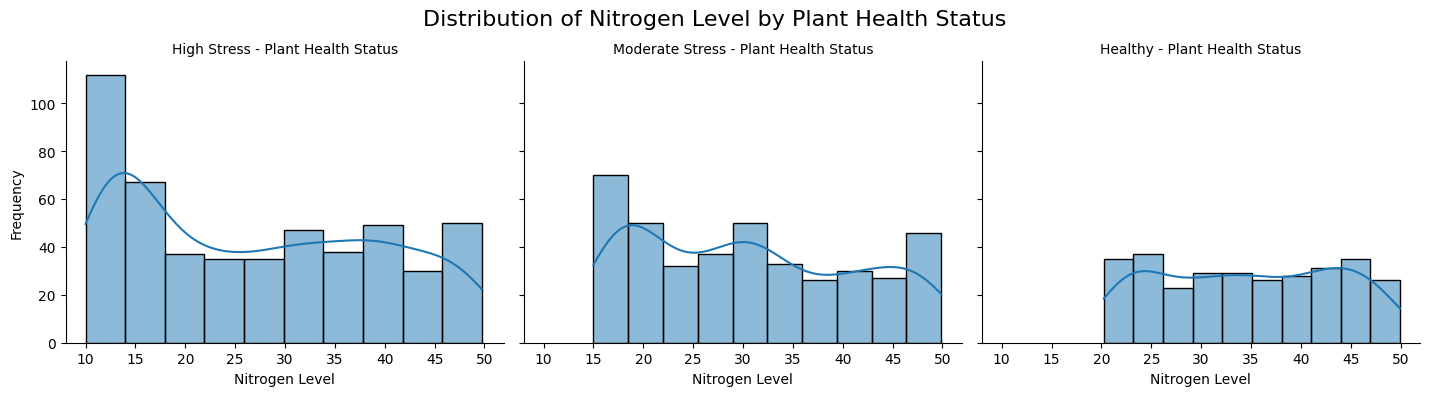

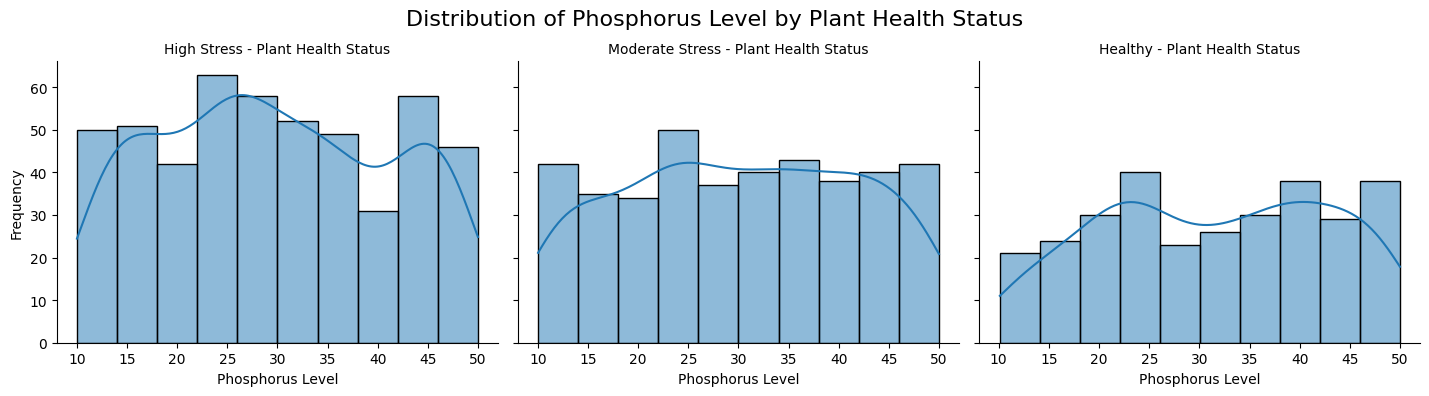

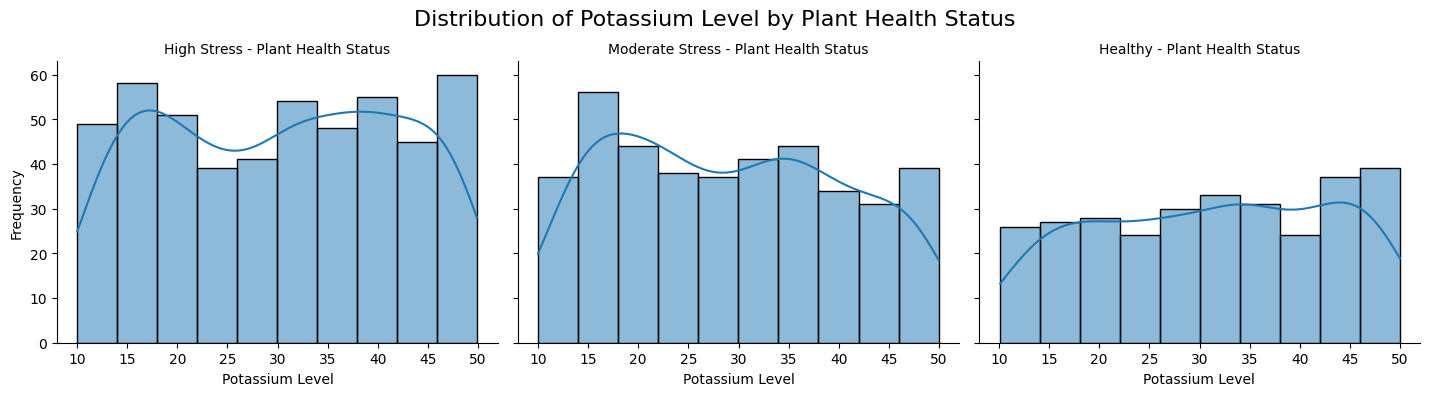

In [96]:
# Soil Properties vs Plant_Health_Status using FacetGrid

# Define soil properties
soil_properties = [
    'Soil_Moisture', 'Soil_Temperature', 'Soil_pH',
    'Nitrogen_Level', 'Phosphorus_Level', 'Potassium_Level'
]

# Create FacetGrid plots for each soil property
for property in soil_properties:
    g = sns.FacetGrid(
        df,
        col='Plant_Health_Status',
        height=4,
        aspect=1.2,
        sharex=True,
        sharey=True
    )
    g.map(sns.histplot, property, kde=True, bins=10, color=None)
    g.set_axis_labels(property.replace('_', ' '), 'Frequency')
    g.set_titles("{col_name} - Plant Health Status")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(
        f'Distribution of {property.replace("_", " ")} by Plant Health Status',
        fontsize=16,
        y=0.98
    )
    plt.show()

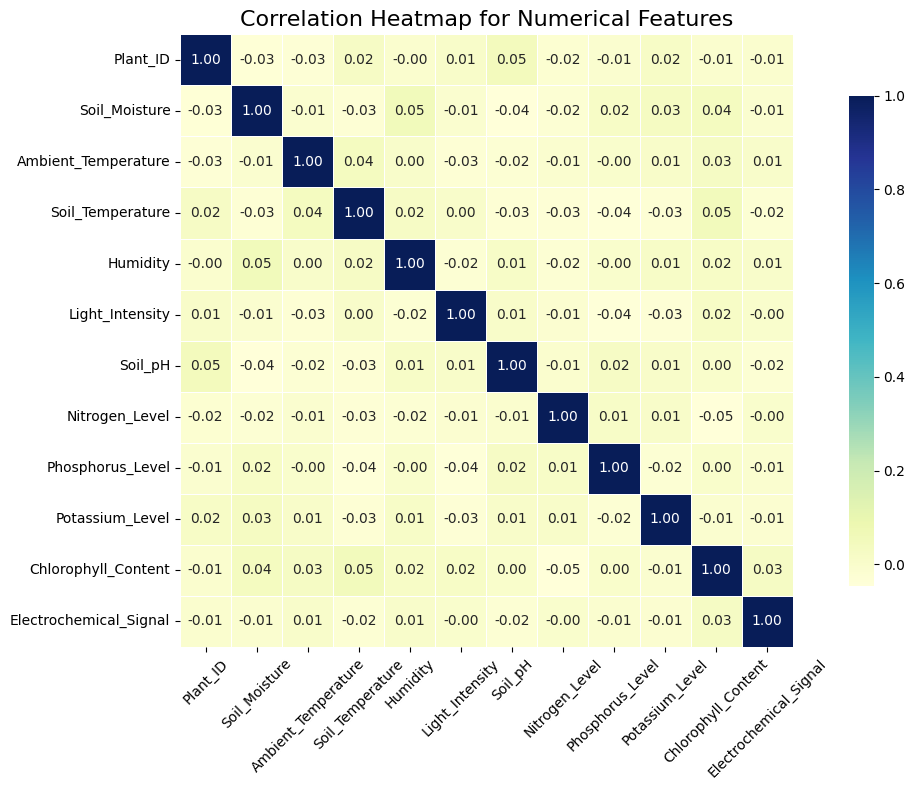

In [97]:
numerical_features = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='YlGnBu',
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Heatmap for Numerical Features', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [98]:
# Convert Timestamp to datetime format and set it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Define features to analyze
time_series_features = [
    'Soil_Moisture', 'Soil_Temperature', 'Ambient_Temperature',
    'Humidity', 'Soil_pH', 'Light_Intensity', 'Nitrogen_Level',
    'Phosphorus_Level', 'Potassium_Level'
]

# Resample data for daily and weekly averages
daily_averages = df[time_series_features].resample('D').mean()
weekly_averages = df[time_series_features].resample('W').mean()

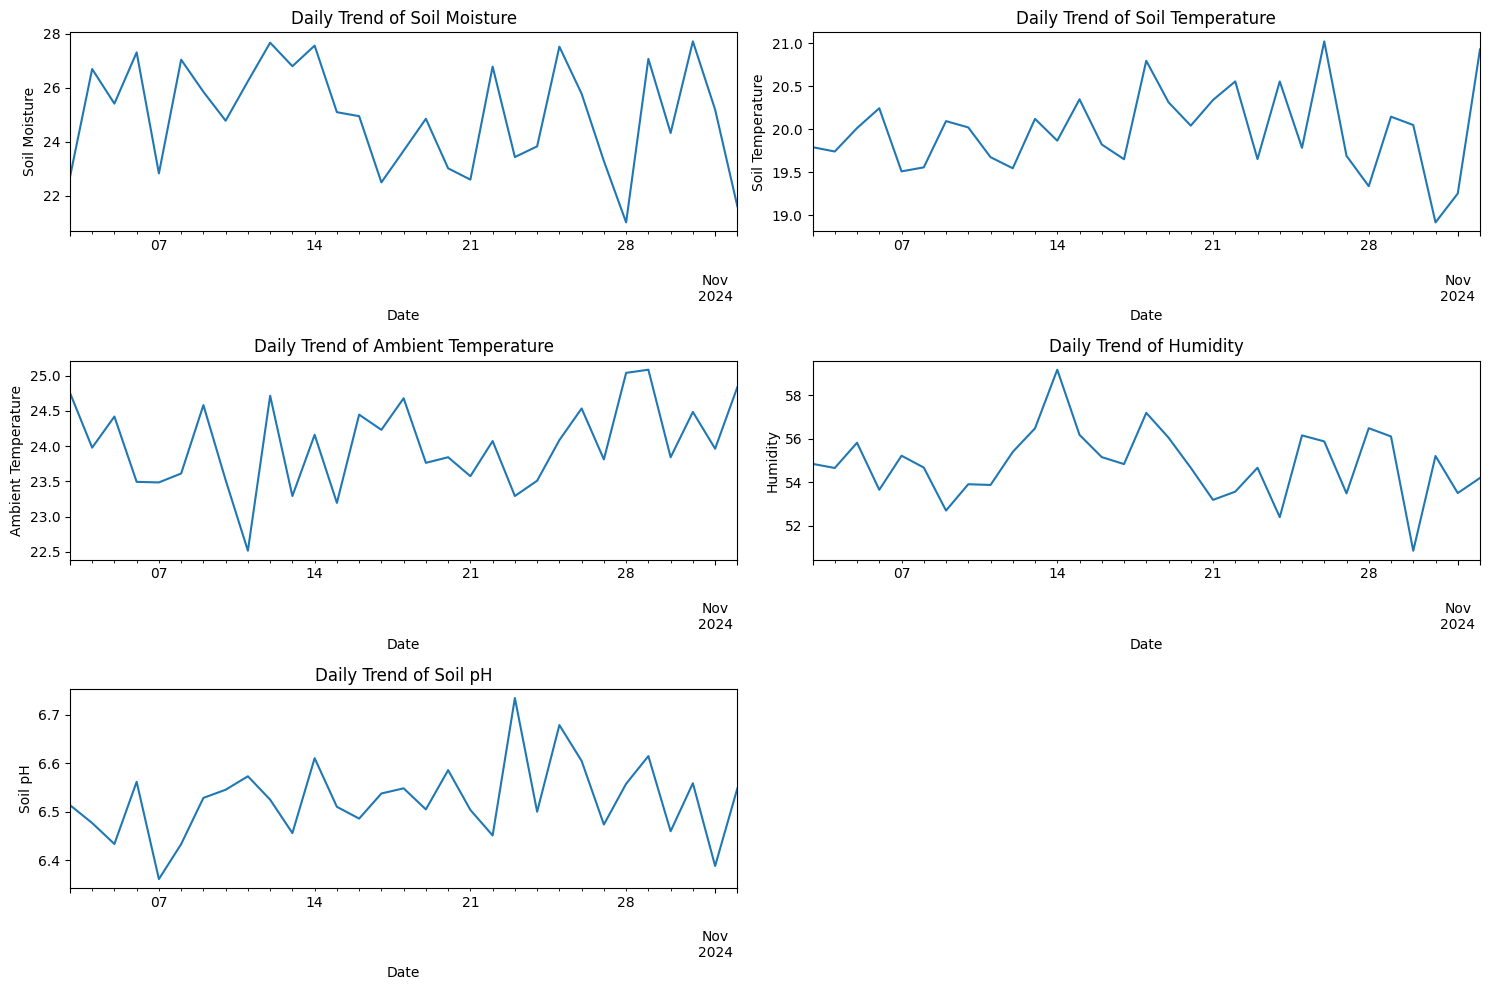

In [99]:
# Plot daily trends for selected features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(time_series_features[:5]):
    plt.subplot(3, 2, i + 1)
    daily_averages[feature].plot(
        title=f'Daily Trend of {feature.replace("_", " ")}',
        ylabel=feature.replace('_', ' '),
        xlabel='Date'
    )
plt.tight_layout()
plt.show()

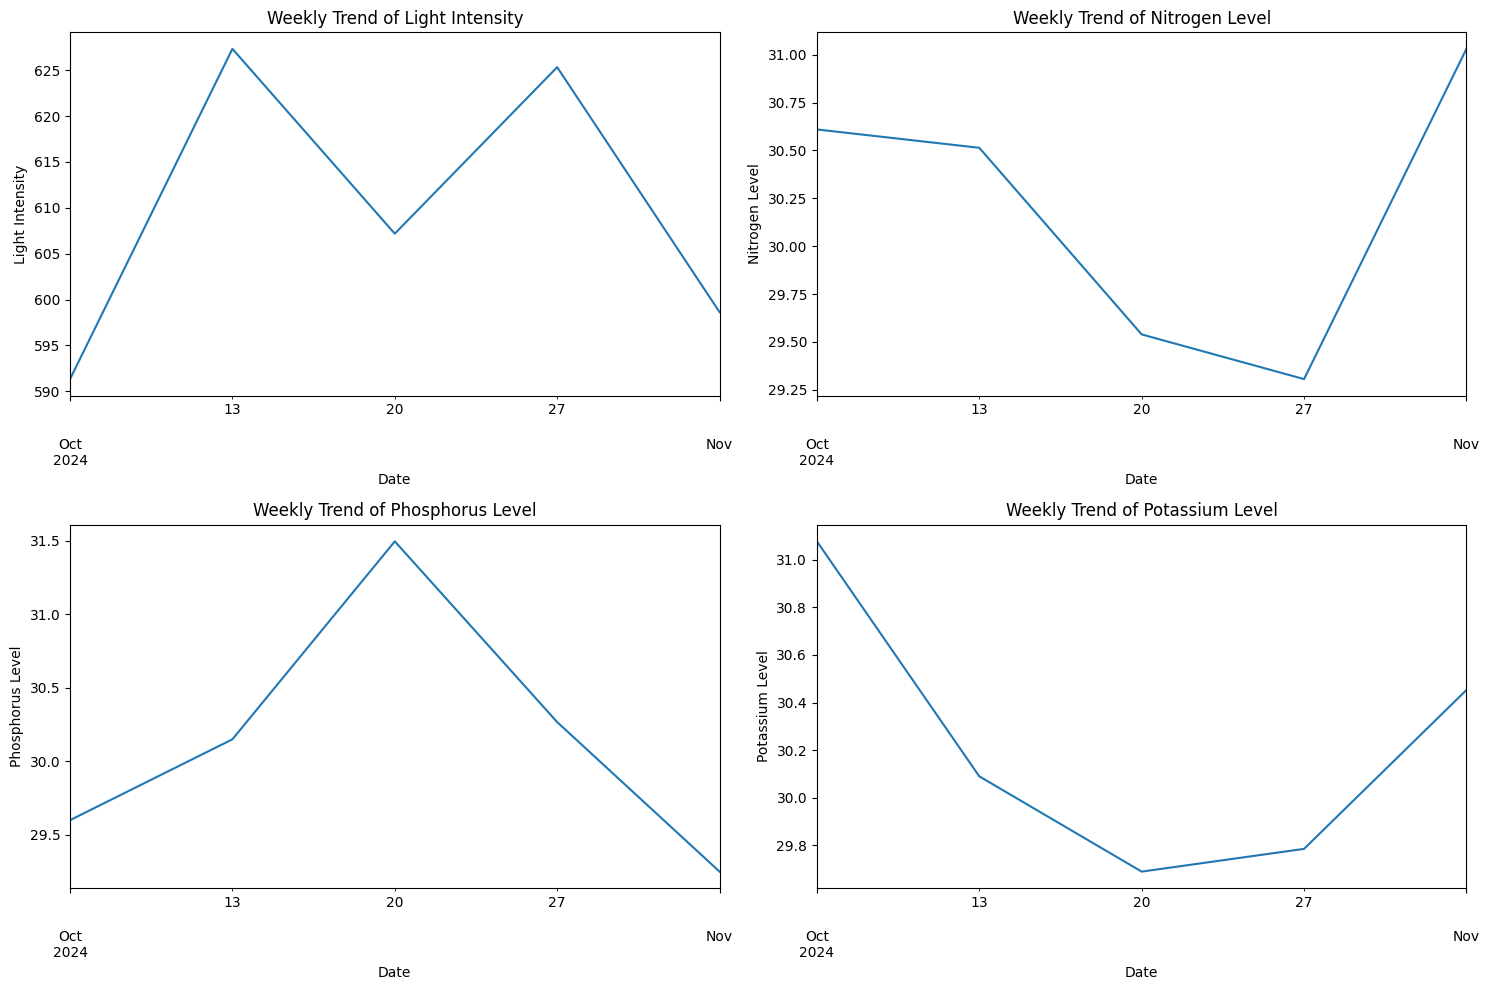

In [100]:
# Plot weekly trends for the remaining 4 features
plt.figure(figsize=(15, 10))
remaining_features = time_series_features[5:]

for i, feature in enumerate(remaining_features):
    plt.subplot(2, 2, i + 1)
    weekly_averages[feature].plot(
        title=f'Weekly Trend of {feature.replace("_", " ")}',
        ylabel=feature.replace('_', ' '),
        xlabel='Date'
    )
plt.tight_layout()
plt.show()

In [104]:
# Custom mapping for Plant_Health_Status
custom_mapping = {'High Stress': 2, 'Moderate Stress': 1, 'Healthy': 0}
df['Plant_Health_Status_Encoded'] = df['Plant_Health_Status'].map(custom_mapping)

# Count unique values in Plant_Health_Status before encoding
unique_value_counts_before = df['Plant_Health_Status'].value_counts()

# Count unique values in Plant_Health_Status_Encoded after encoding
unique_value_counts_after = df['Plant_Health_Status_Encoded'].value_counts()

# Display unique values before and after encoding
print("----- Unique Values in Plant Health Status Before Encoding ----- ")
print(unique_value_counts_before)

print("\n----- Unique Values in Plant Health Status After Encoding ----- ")
print(unique_value_counts_after)

----- Unique Values in Plant Health Status Before Encoding ----- 
Plant_Health_Status
High Stress        500
Moderate Stress    401
Healthy            299
Name: count, dtype: int64

----- Unique Values in Plant Health Status After Encoding ----- 
Plant_Health_Status_Encoded
2    500
1    401
0    299
Name: count, dtype: int64


In [105]:
numerical_features = df.select_dtypes(include=[np.number]).columns

# Z-score Method
z_scores = zscore(df[numerical_features])
outliers_zscore = (np.abs(z_scores) > 3).sum(axis=0)
print("Outliers Detected with Z-scores:\n", outliers_zscore)

Outliers Detected with Z-scores:
 [0 0 0 0 0 0 0 0 0 0 0 0 0]


In [106]:
# Drop the original Plant_Health_Status column
df= df.drop(columns=['Plant_Health_Status', 'Week'])

In [107]:
# Calculate correlations
correlations = df.corr()['Plant_Health_Status_Encoded'].sort_values(ascending=False)

# Convert to DataFrame
correlation_table = correlations.to_frame(name='Correlation with Plant_Health_Status_Encoded').reset_index()
correlation_table.rename(columns={'index': 'Feature'}, inplace=True)

# Display the table
display(correlation_table)

Feature  Correlation with Plant_Health_Status_Encoded
0   Plant_Health_Status_Encoded                                      1.000000
1                       Soil_pH                                      0.039609
2                      Plant_ID                                      0.031788
3               Light_Intensity                                      0.026331
4        Electrochemical_Signal                                      0.020962
5           Ambient_Temperature                                     -0.000692
6           Chlorophyll_Content                                     -0.007242
7              Soil_Temperature                                     -0.008938
8               Potassium_Level                                     -0.022879
9                      Humidity                                     -0.044952
10             Phosphorus_Level                                     -0.058728
11               Nitrogen_Level                                     -0.269102
12                Soil_Moisture                                     -0.774851

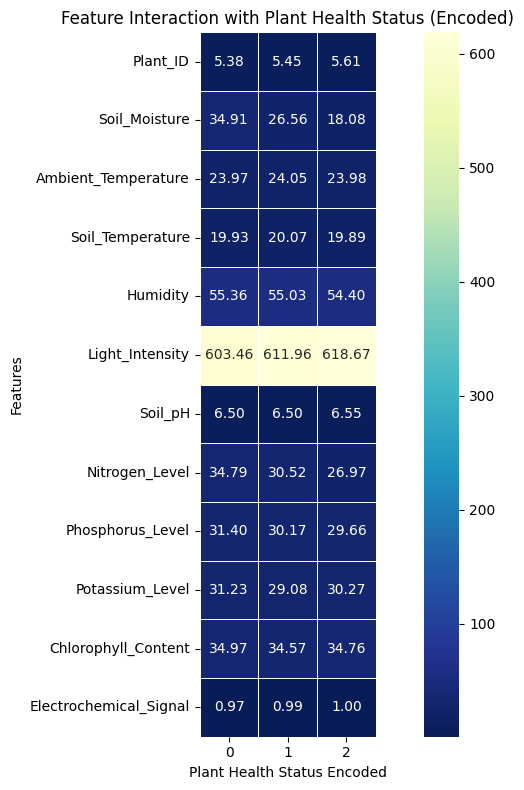

In [108]:
# Ensure 'Plant_Health_Status_Encoded' is included and calculate mean values
status_correlation = df.groupby('Plant_Health_Status_Encoded').mean().T

plt.figure(figsize=(10, 8))
sns.heatmap(status_correlation, annot=True, cmap='YlGnBu_r', fmt='.2f', linewidths=0.5, square=True, cbar_kws={"shrink": 1})
plt.title('Feature Interaction with Plant Health Status (Encoded)')
plt.ylabel('Features')
plt.xlabel('Plant Health Status Encoded')
plt.tight_layout()
plt.show()

In [109]:
# Define features and target
X = df.drop(columns=['Plant_Health_Status_Encoded'])  # Features
y = df['Plant_Health_Status_Encoded']  # Target

In [110]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shapes of the splits for verification
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (960, 12)
X_test Shape: (240, 12)
y_train Shape: (960,)
y_test Shape: (240,)


In [111]:
# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [112]:
# Initialize models
models = {
    "KNN Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Display model names to confirm initialization
print("Models initialized:", list(models.keys()))

Models initialized: ['KNN Classifier', 'Decision Tree', 'Random Forest', 'Gradient Boosting']



Model: KNN Classifier
Accuracy: 0.64
AUC: 0.81


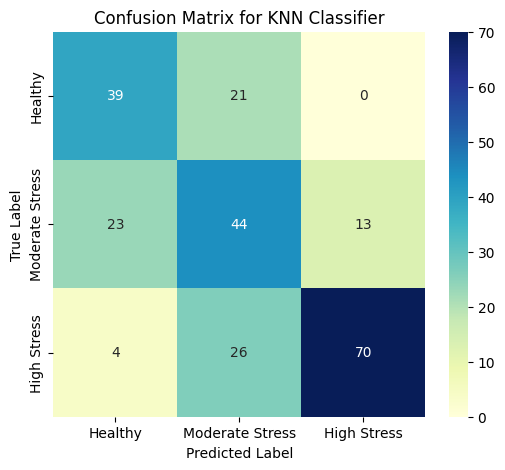

                 precision    recall  f1-score   support

        Healthy       0.59      0.65      0.62        60
Moderate Stress       0.48      0.55      0.51        80
    High Stress       0.84      0.70      0.77       100

       accuracy                           0.64       240
      macro avg       0.64      0.63      0.63       240
   weighted avg       0.66      0.64      0.65       240


Model: Decision Tree
Accuracy: 0.99
AUC: 0.99


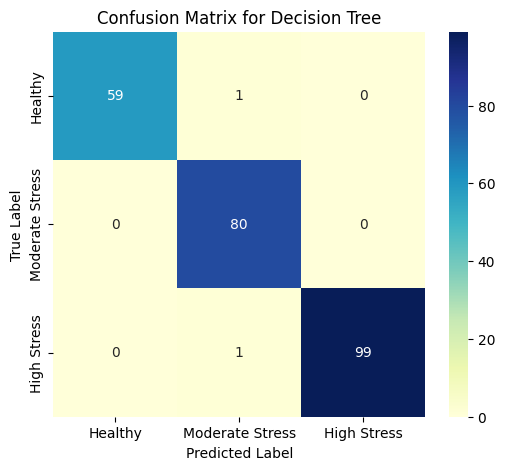

                 precision    recall  f1-score   support

        Healthy       1.00      0.98      0.99        60
Moderate Stress       0.98      1.00      0.99        80
    High Stress       1.00      0.99      0.99       100

       accuracy                           0.99       240
      macro avg       0.99      0.99      0.99       240
   weighted avg       0.99      0.99      0.99       240


Model: Random Forest
Accuracy: 0.99
AUC: 1.00


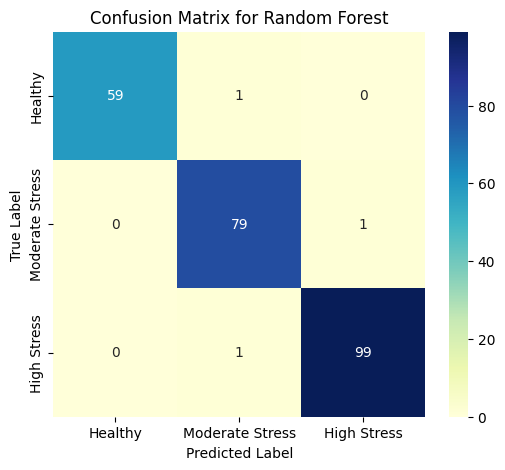

                 precision    recall  f1-score   support

        Healthy       1.00      0.98      0.99        60
Moderate Stress       0.98      0.99      0.98        80
    High Stress       0.99      0.99      0.99       100

       accuracy                           0.99       240
      macro avg       0.99      0.99      0.99       240
   weighted avg       0.99      0.99      0.99       240


Model: Gradient Boosting
Accuracy: 0.99
AUC: 0.99


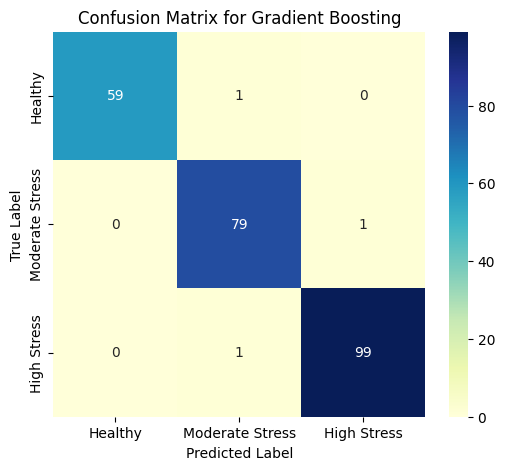

                 precision    recall  f1-score   support

        Healthy       1.00      0.98      0.99        60
Moderate Stress       0.98      0.99      0.98        80
    High Stress       0.99      0.99      0.99       100

       accuracy                           0.99       240
      macro avg       0.99      0.99      0.99       240
   weighted avg       0.99      0.99      0.99       240



In [113]:
# Initialize lists to store results
results = []

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)
        auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    else:
        auc = None

    # Store results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred, target_names=['Healthy', 'Moderate Stress', 'High Stress'])
    })

# Display results for each model
for result in results:
    print(f"\nModel: {result['Model']}")
    print(f"Accuracy: {result['Accuracy']:.2f}")
    if result["AUC"] is not None:
        print(f"AUC: {result['AUC']:.2f}")

    # Confusion Matrix Visualization
    cm = result["Confusion Matrix"]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Healthy', 'Moderate Stress', 'High Stress'],
                yticklabels=['Healthy', 'Moderate Stress', 'High Stress'])
    plt.title(f'Confusion Matrix for {result["Model"]}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print Classification Report
    print(result["Classification Report"])

In [114]:
# Prepare a summary table for model evaluation
evaluation_summary = []

# Extract the key metrics for each model
for result in results:
    evaluation_summary.append({
        "Model": result["Model"],
        "Accuracy": result["Accuracy"],
        "AUC": result["AUC"]
    })

evaluation_summary_df = pd.DataFrame(evaluation_summary)

# Sort by accuracy and display
display(evaluation_summary_df.sort_values(by="Accuracy", ascending=False))

Model  Accuracy       AUC
1      Decision Tree  0.991667  0.993472
2      Random Forest  0.987500  0.999664
3  Gradient Boosting  0.987500  0.993996
0     KNN Classifier  0.637500  0.813661

In [115]:
# Select the Model with the Highest AUC
best_model_name = max(results, key=lambda x: x["AUC"] if x["AUC"] is not None else -1)["Model"]
best_model = models[best_model_name]
print(f"The best model based on AUC is: {best_model_name}")

The best model based on AUC is: Random Forest


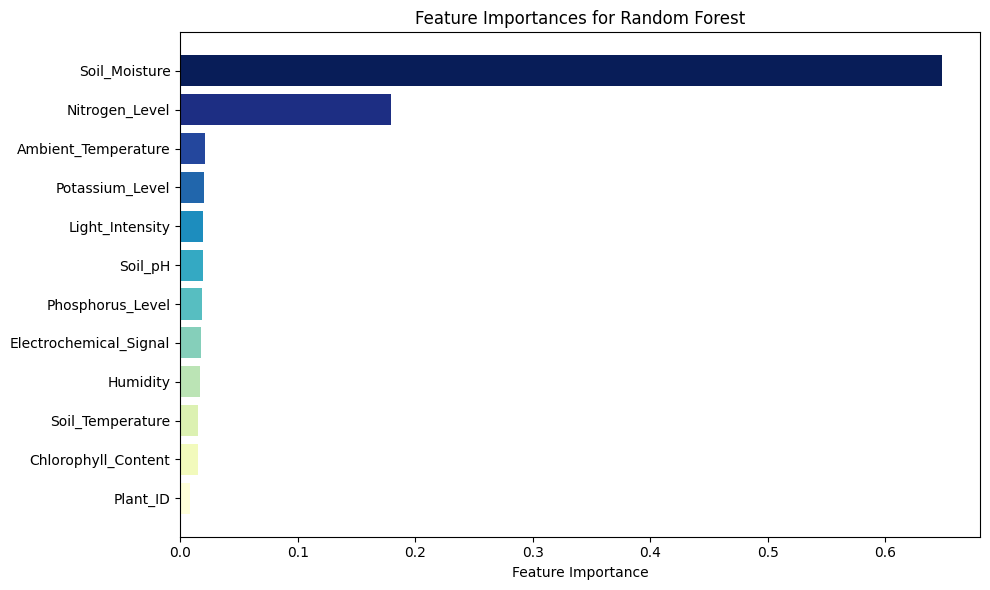

In [116]:
# Plot the Feature Importances
if hasattr(best_model, "feature_importances_"):  # Check if the model has feature_importances_
    feature_importances = best_model.feature_importances_
    feature_names = X.columns

    plt.figure(figsize=(10, 6))
    sorted_idx = feature_importances.argsort()[::-1]

    # Using color palette 'winter' for the bars
    colors = plt.cm.YlGnBu_r(np.linspace(0, 1, len(feature_importances)))

    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center', color=colors)
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importances for {best_model_name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"{best_model_name} does not support feature importances.")

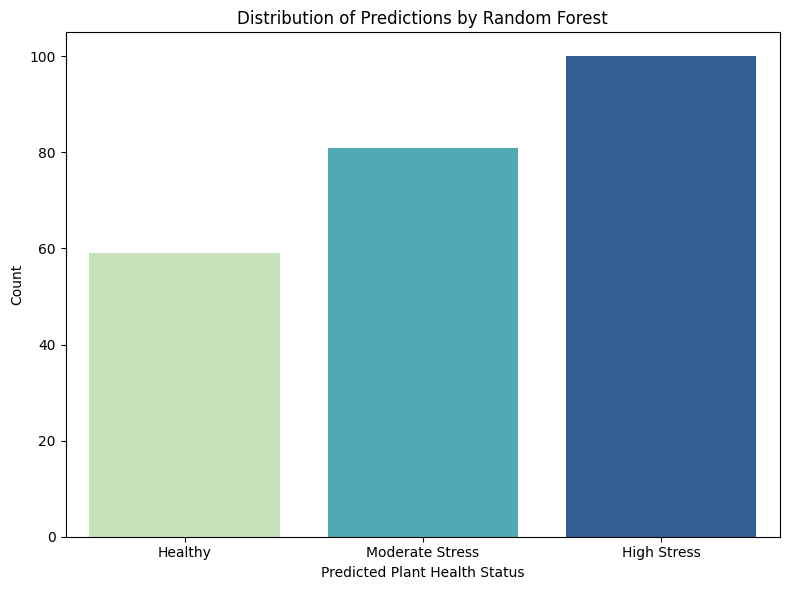

In [117]:
# Generate Predictions
y_pred_best = best_model.predict(X_test_scaled)

# Plot the Distribution of Predictions
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred_best, palette='YlGnBu')
plt.xticks([0, 1, 2], labels=["Healthy", "Moderate Stress", "High Stress"])
plt.xlabel("Predicted Plant Health Status")
plt.ylabel("Count")
plt.title(f"Distribution of Predictions by {best_model_name}")
plt.tight_layout()
plt.show()

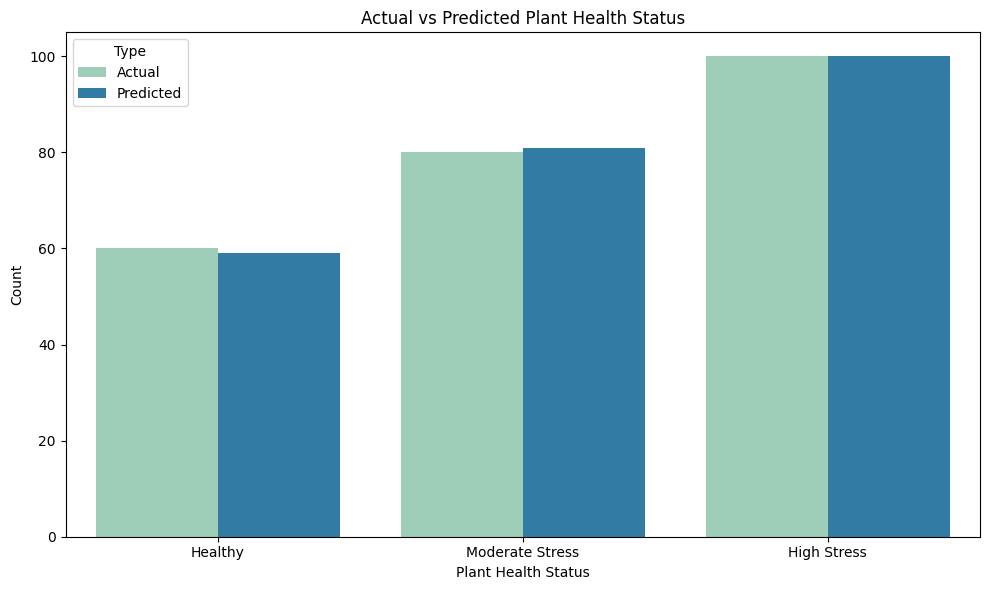

In [118]:
plt.figure(figsize=(10, 6))

# Convert the actual and predicted values to a DataFrame for comparison
actual_vs_predicted = pd.DataFrame({
    'Actual': y_test,
    'Predicted': best_model.predict(X_test_scaled)
})

sns.countplot(
    data=actual_vs_predicted.melt(var_name='Type', value_name='Plant Health Status'),
    x='Plant Health Status', hue='Type', palette='YlGnBu'
)

plt.xticks([0, 1, 2], labels=["Healthy", "Moderate Stress", "High Stress"])
plt.xlabel("Plant Health Status")
plt.ylabel("Count")
plt.title("Actual vs Predicted Plant Health Status")
plt.legend(title="Type", loc="upper left")
plt.tight_layout()
plt.show()